In [1]:
import pandas as pd
import numpy as np
from matplotlib.pyplot import subplots, cm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.model_selection import GridSearchCV, cross_validate, KFold
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, accuracy_score, roc_auc_score

from ISLP.utils import load_data, confusion_table
from ISLP.svm import plot as plot_svm

In [2]:
rc = {
    "axes.facecolor": "#F8F8F8",
    "figure.facecolor": "#F8F8F8",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7" + "30",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4,
}

sns.set(rc=rc)
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

from colorama import Style, Fore
blk = Style.BRIGHT + Fore.BLACK
mgt = Style.BRIGHT + Fore.MAGENTA
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

plt.style.use('fivethirtyeight')

In [3]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

In [7]:
# summary statistics
#train_data.drop(columns=['CustomerId', 'id']).describe().style.background_gradient()
train_data.describe().style.background_gradient()

In [9]:
test_data.describe().style.background_gradient()

In [11]:
sample_submission.describe().style.background_gradient()

데이터에 결측치가 없다. 따라서 아래 두 그림은 결측치가 없다는 것을 보여준다. 

C:\Users\admin\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


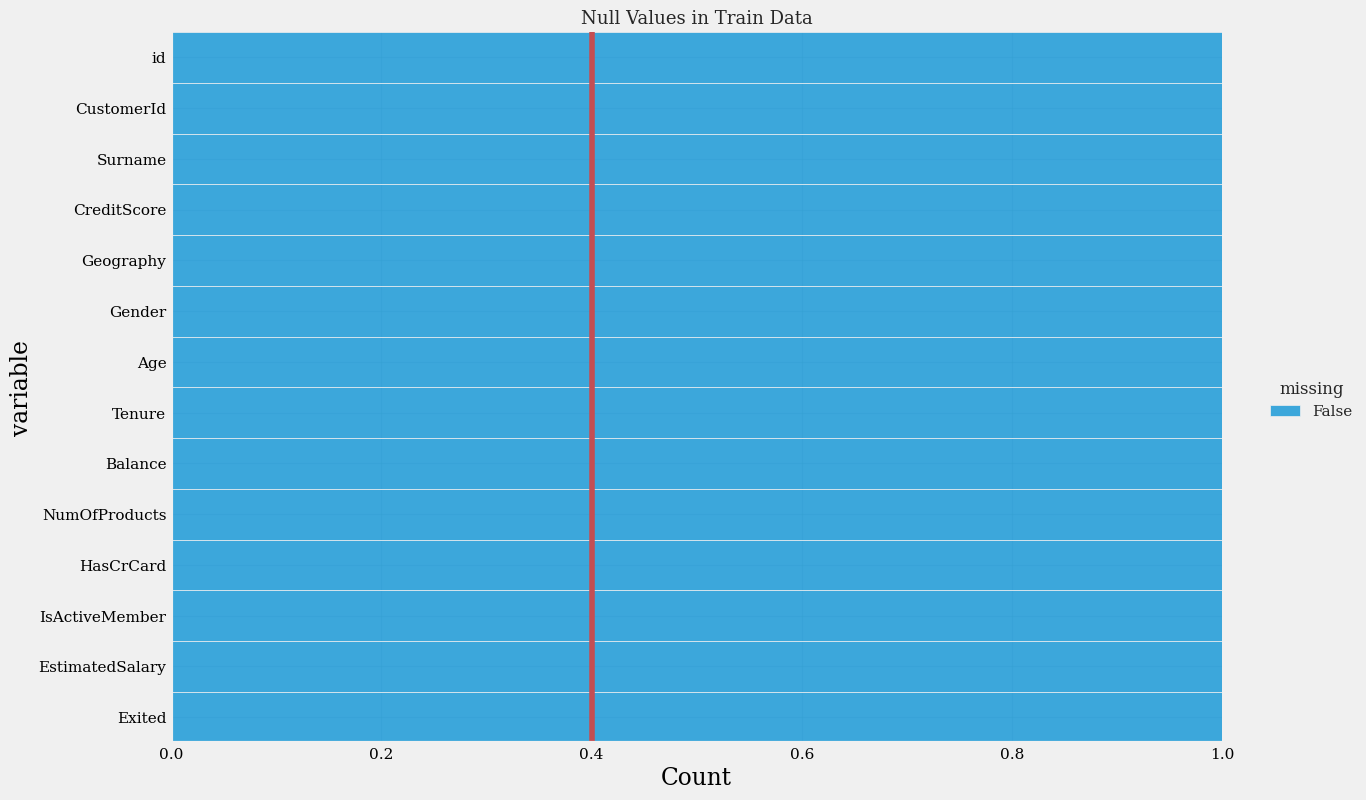

C:\Users\admin\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


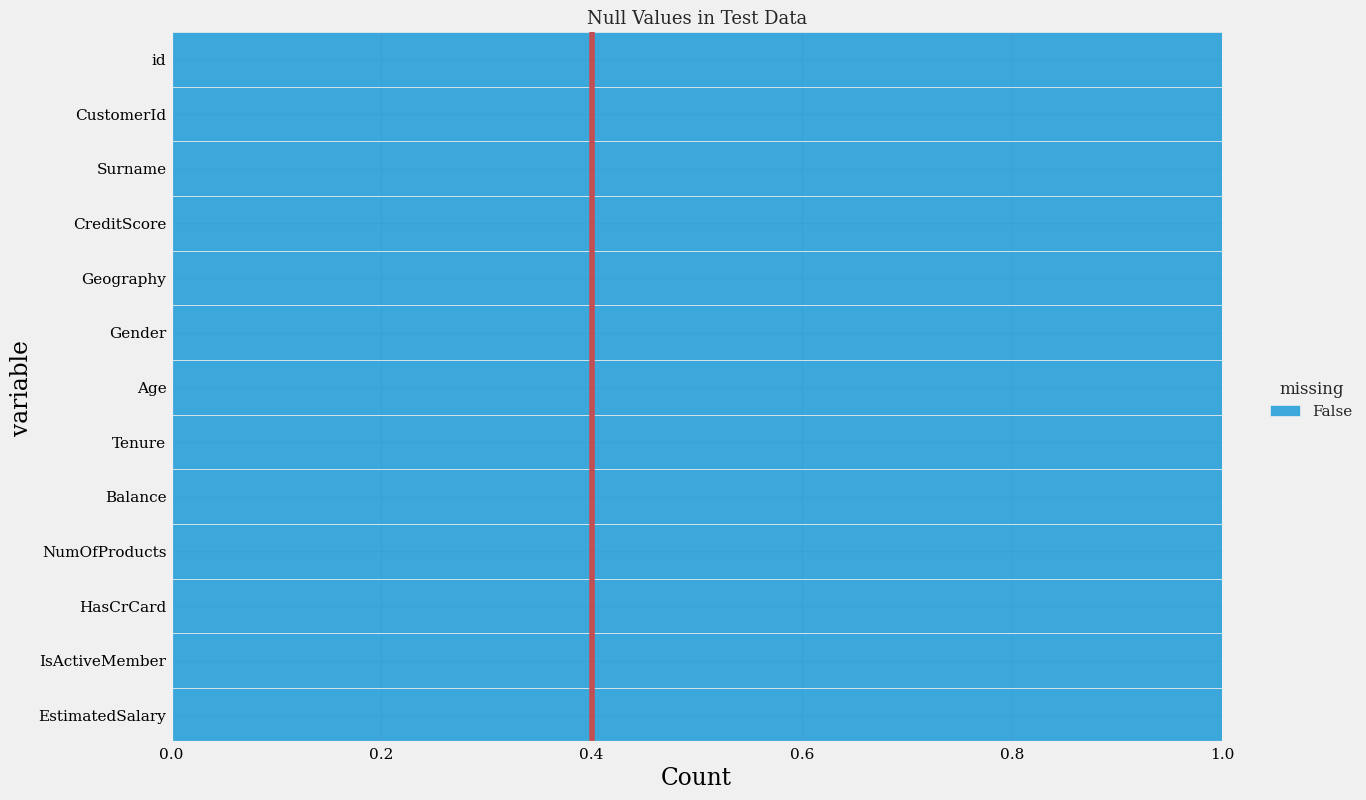

In [14]:
#train_data
sns.displot(data=train_data.isnull().melt(value_name='missing'),
    y='variable',
    hue='missing',
    multiple='fill',
    height=8,
#     width=10,
    aspect=1.6
)

# specifying a threshold value
plt.axvline(0.4, color='r')
plt.title('Null Values in Train Data', fontsize=13)
plt.show()

# test data
sns.displot(data=test_data.isnull().melt(value_name='missing'),
    y='variable',
    hue='missing',
    multiple='fill',
    height=8,
#     width=10,
    aspect=1.6
)

# specifying a threshold value
plt.axvline(0.4, color='r')
plt.title('Null Values in Test Data', fontsize=13)
plt.show()

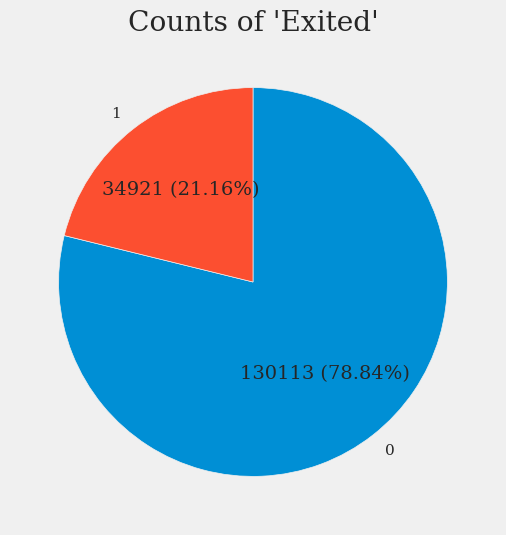

In [16]:
counts = train_data['Exited'].value_counts().sort_index()

# Define a formatting function for autopct
def func(pct, allvalues):
    absolute = int(round(pct/100.*sum(allvalues)))
    return f"{absolute} ({pct:.2f}%)"


plt.figure(figsize=(6,6))
plt.pie(
    counts,
    labels=counts.index.tolist(),
    autopct=lambda pct: func(pct, counts),
    #colors=['#66b3ff','#ff9999'],  # Optional: custom colors
    startangle=90,
    counterclock=False
)
plt.title("Counts of 'Exited'")
plt.show()

데이터중에서 동일한 값이 많은 경우는 범주형 자료로 분류하였다. 각 열의 유니크한 값의 갯수를 센후에 일정수(12)가 넘는 열이 수치형 값으로 보았고, 나머지는 범주형으로 보았다. 따라서 재직기간이 범주형 변수로 분류되었다. 

In [19]:
# Unique value counts for each column
unique_counts = train_data.nunique()

# Threshold to distinguish continuous and categorical
threshold = 12

continuous_vars = unique_counts[unique_counts > threshold].index.tolist()
categorical_vars = unique_counts[unique_counts <= threshold].index.tolist()

# Removing the 'outcome' from categorical since it's our target variable
if 'outcome' in categorical_vars:
    categorical_vars.remove('outcome')
if 'id' in continuous_vars:
    continuous_vars.remove('id')

print(f"Categorical Variables: {categorical_vars}")
print(f"Continousl/Numerical Variables: {continuous_vars}")

Categorical Variables: ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited']
Continousl/Numerical Variables: ['CustomerId', 'Surname', 'CreditScore', 'Age', 'Balance', 'EstimatedSalary']


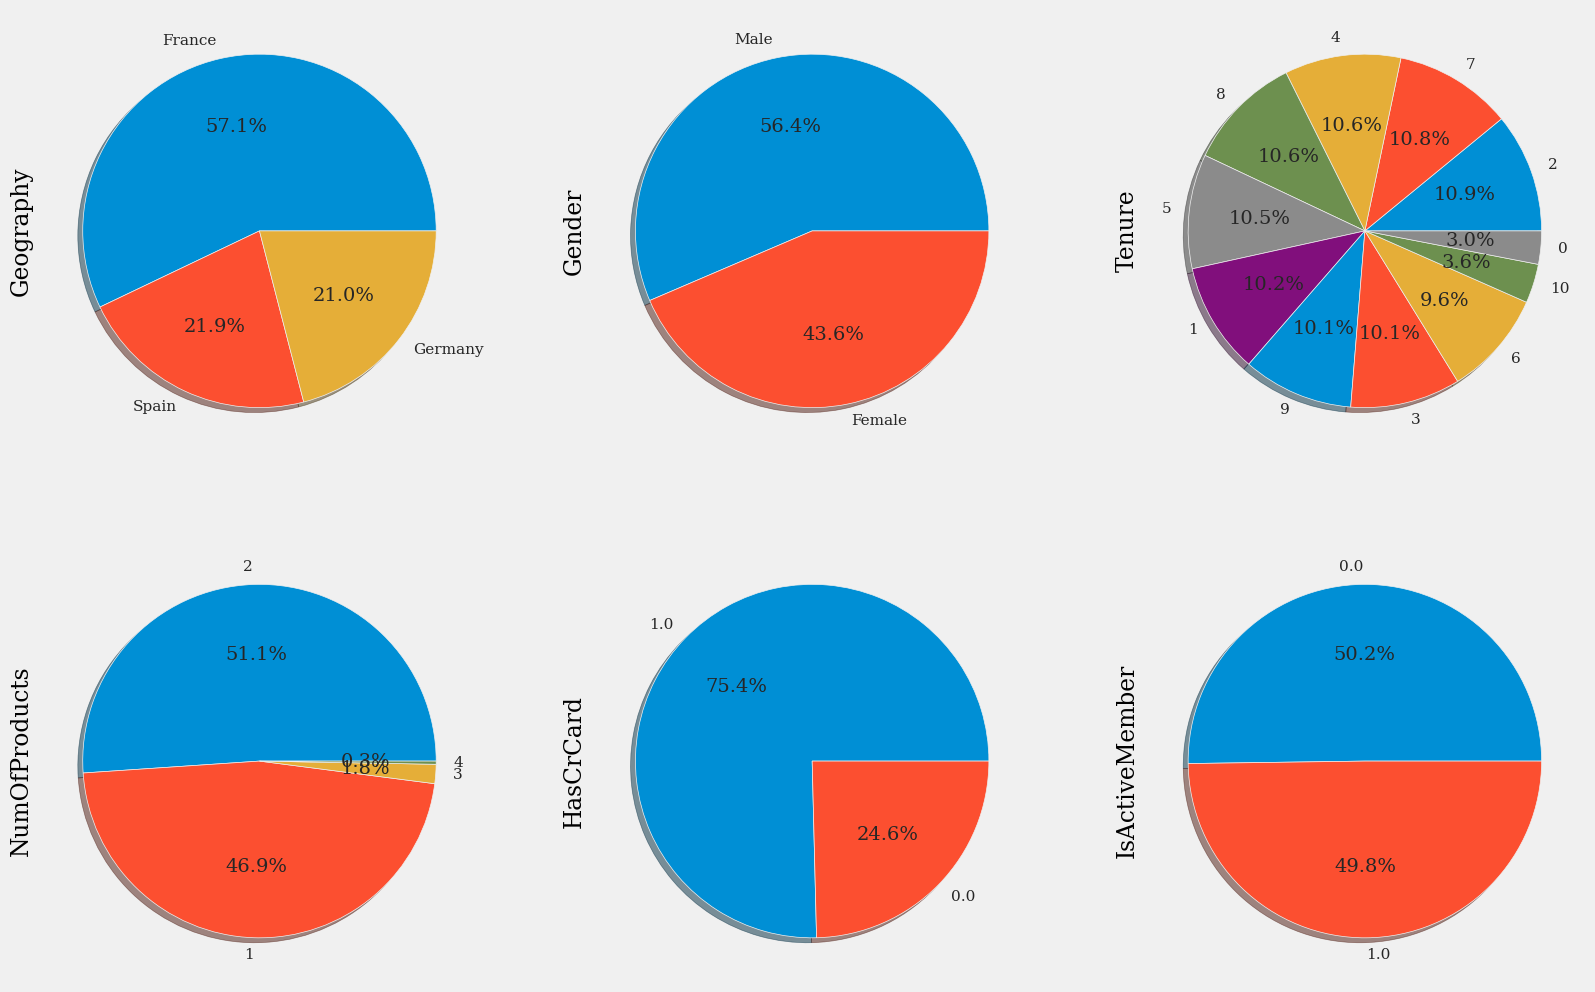

In [21]:
if 'Exited' in categorical_vars:
    categorical_vars.remove('Exited')

plt.figure(figsize=(18,12))
for i, column in enumerate(categorical_vars):    
    plt.subplot(2,3,i+1)
    train_data[column].value_counts().plot.pie(autopct='%1.1f%%', shadow=True)
    plt.ylabel(f'{column}')

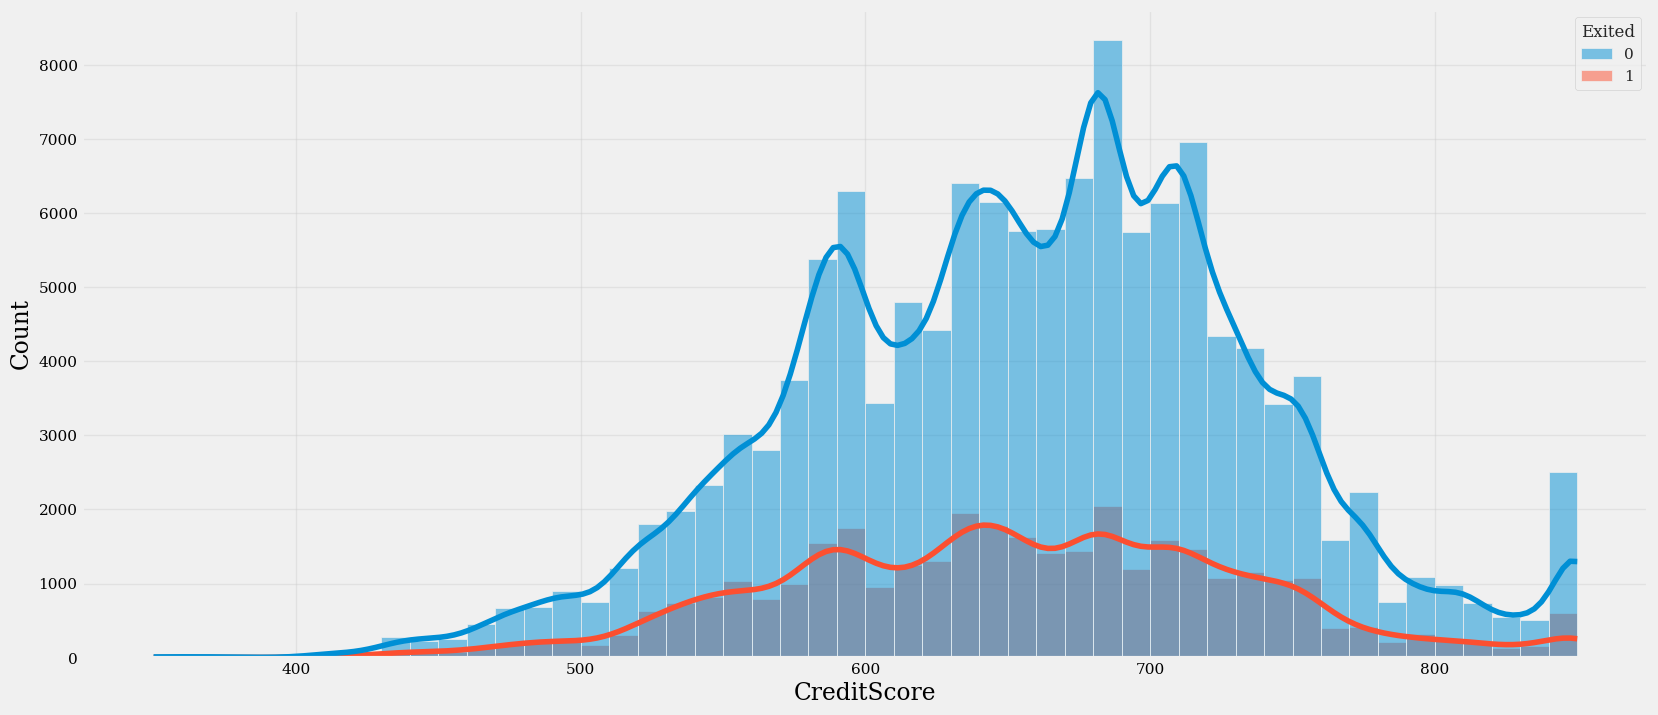

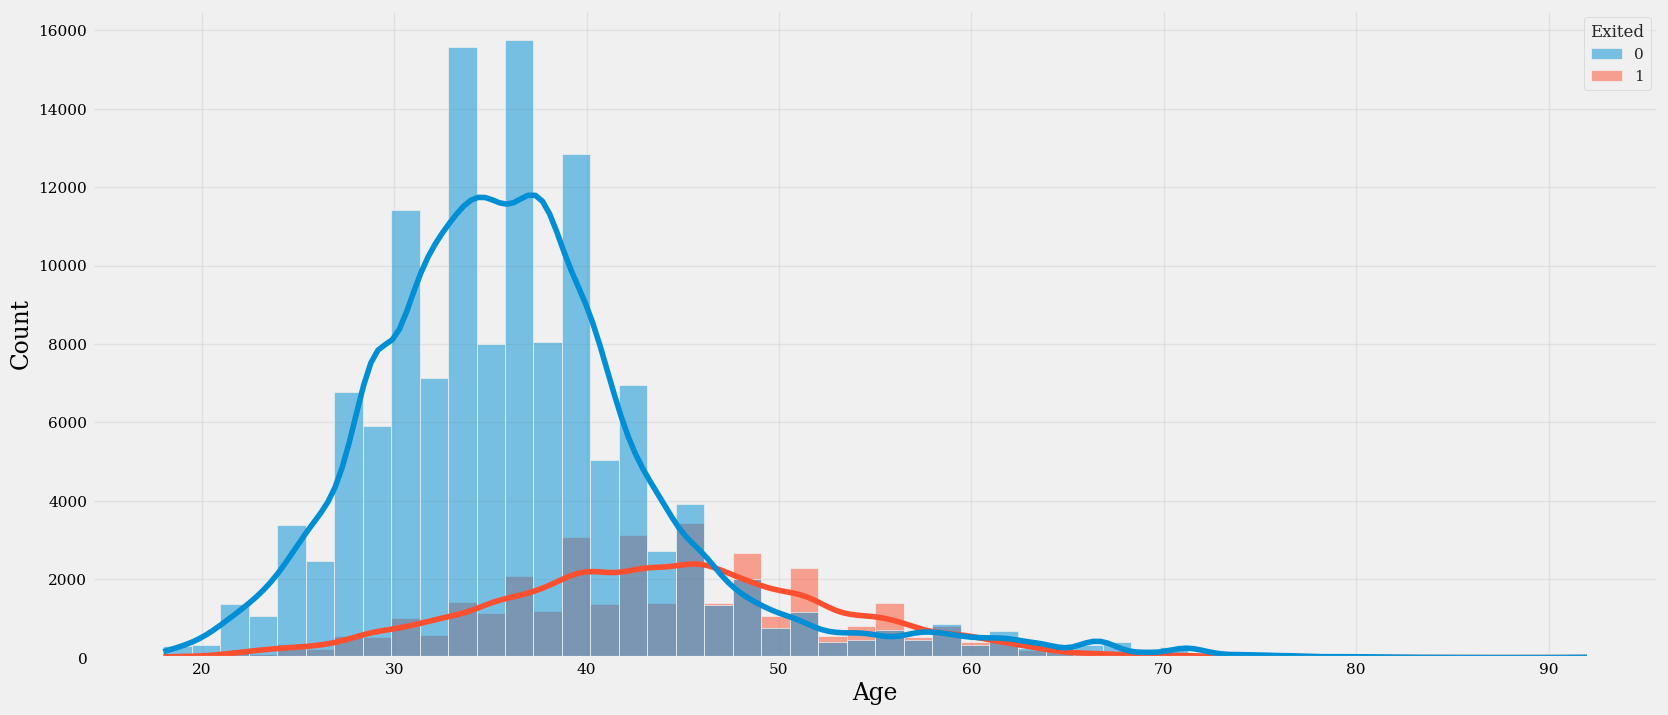

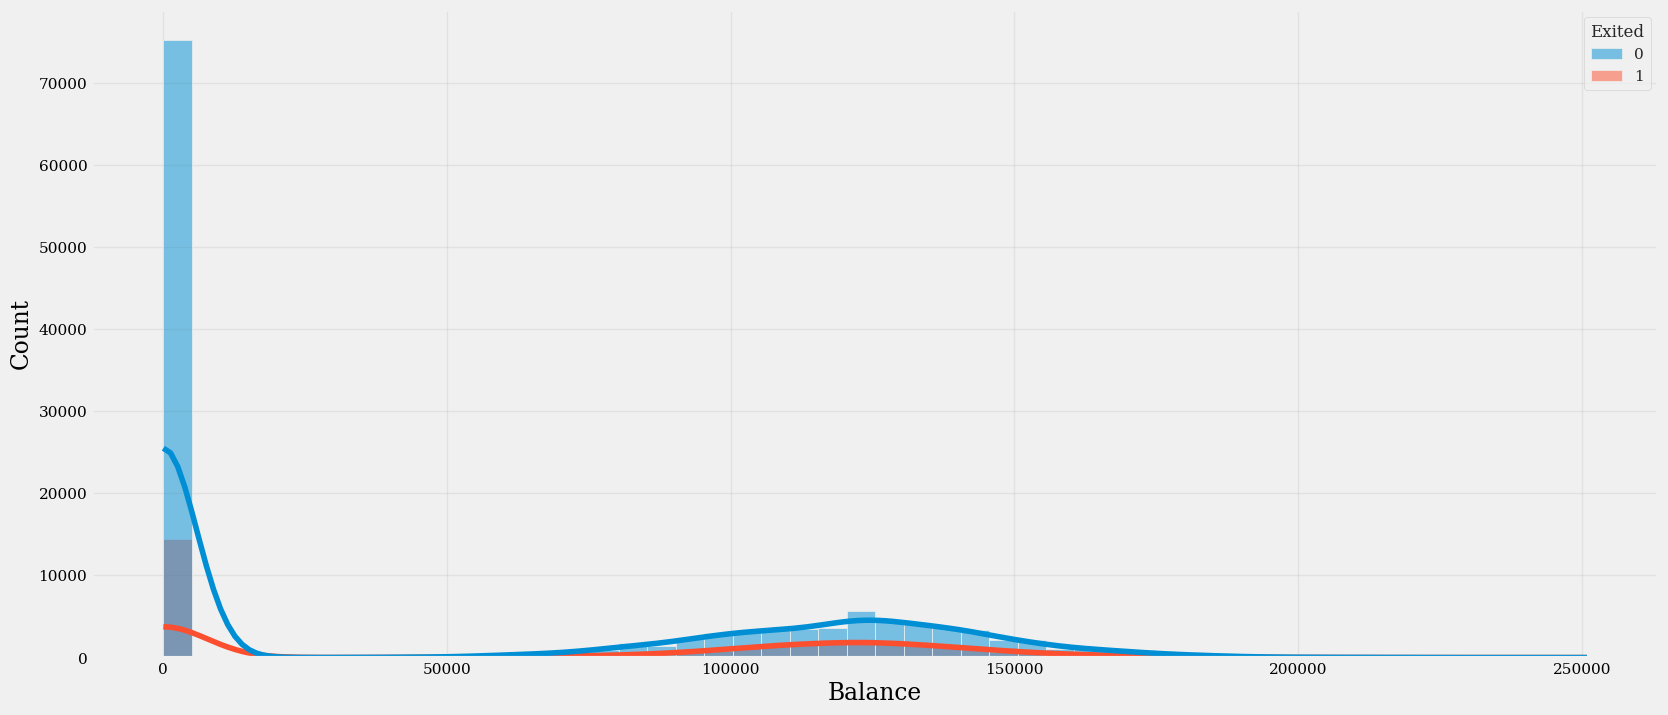

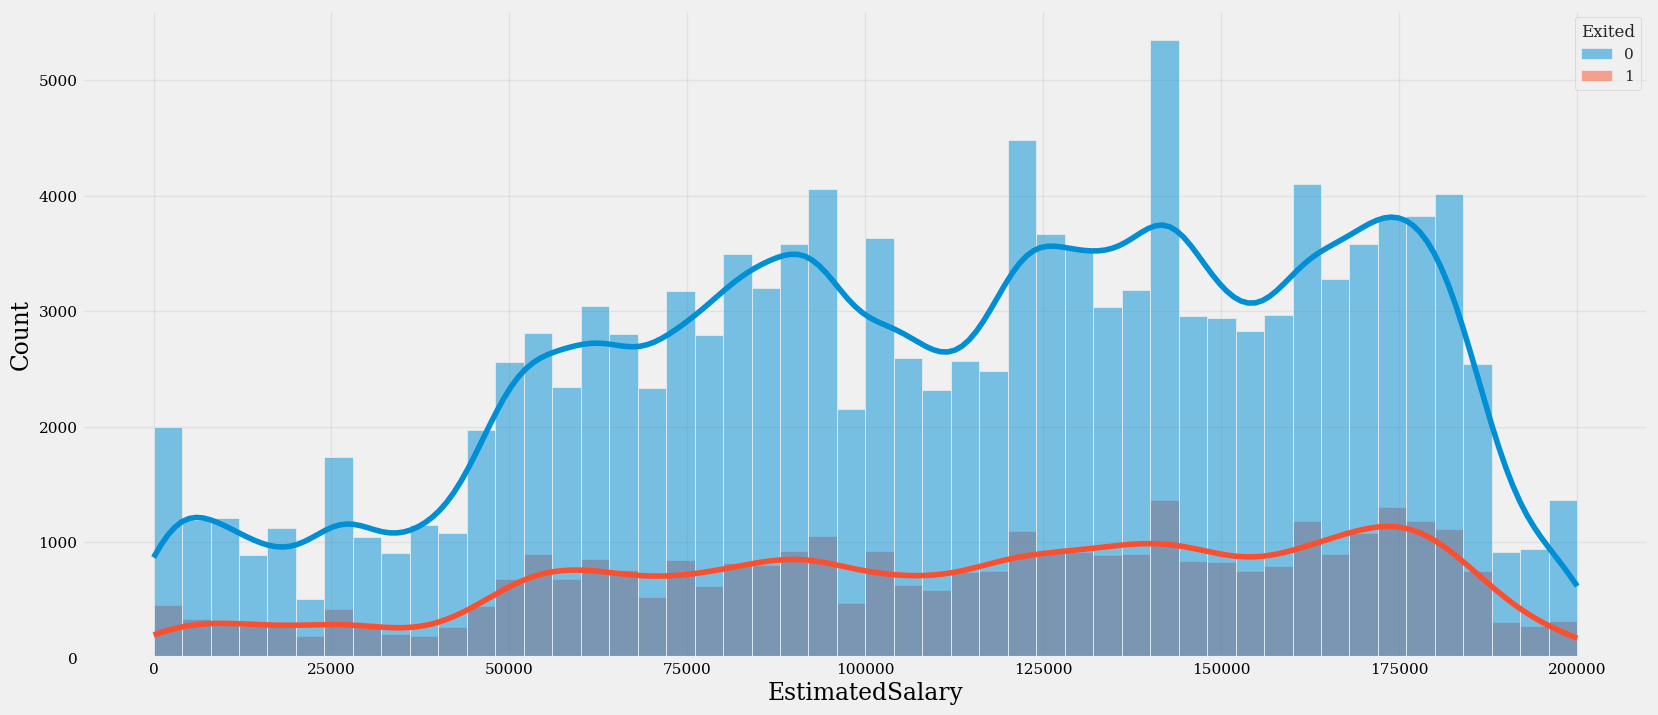

In [23]:
if 'CustomerId' in continuous_vars:
    continuous_vars.remove('CustomerId')
if 'Surname' in continuous_vars:    
    continuous_vars.remove('Surname')

for column in continuous_vars:
    fig, ax = plt.subplots(figsize=(18, 8))
    fig = sns.histplot(data=train_data, x=column, hue="Exited", bins=50, kde=True)
    plt.show()

C:\Users\admin\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


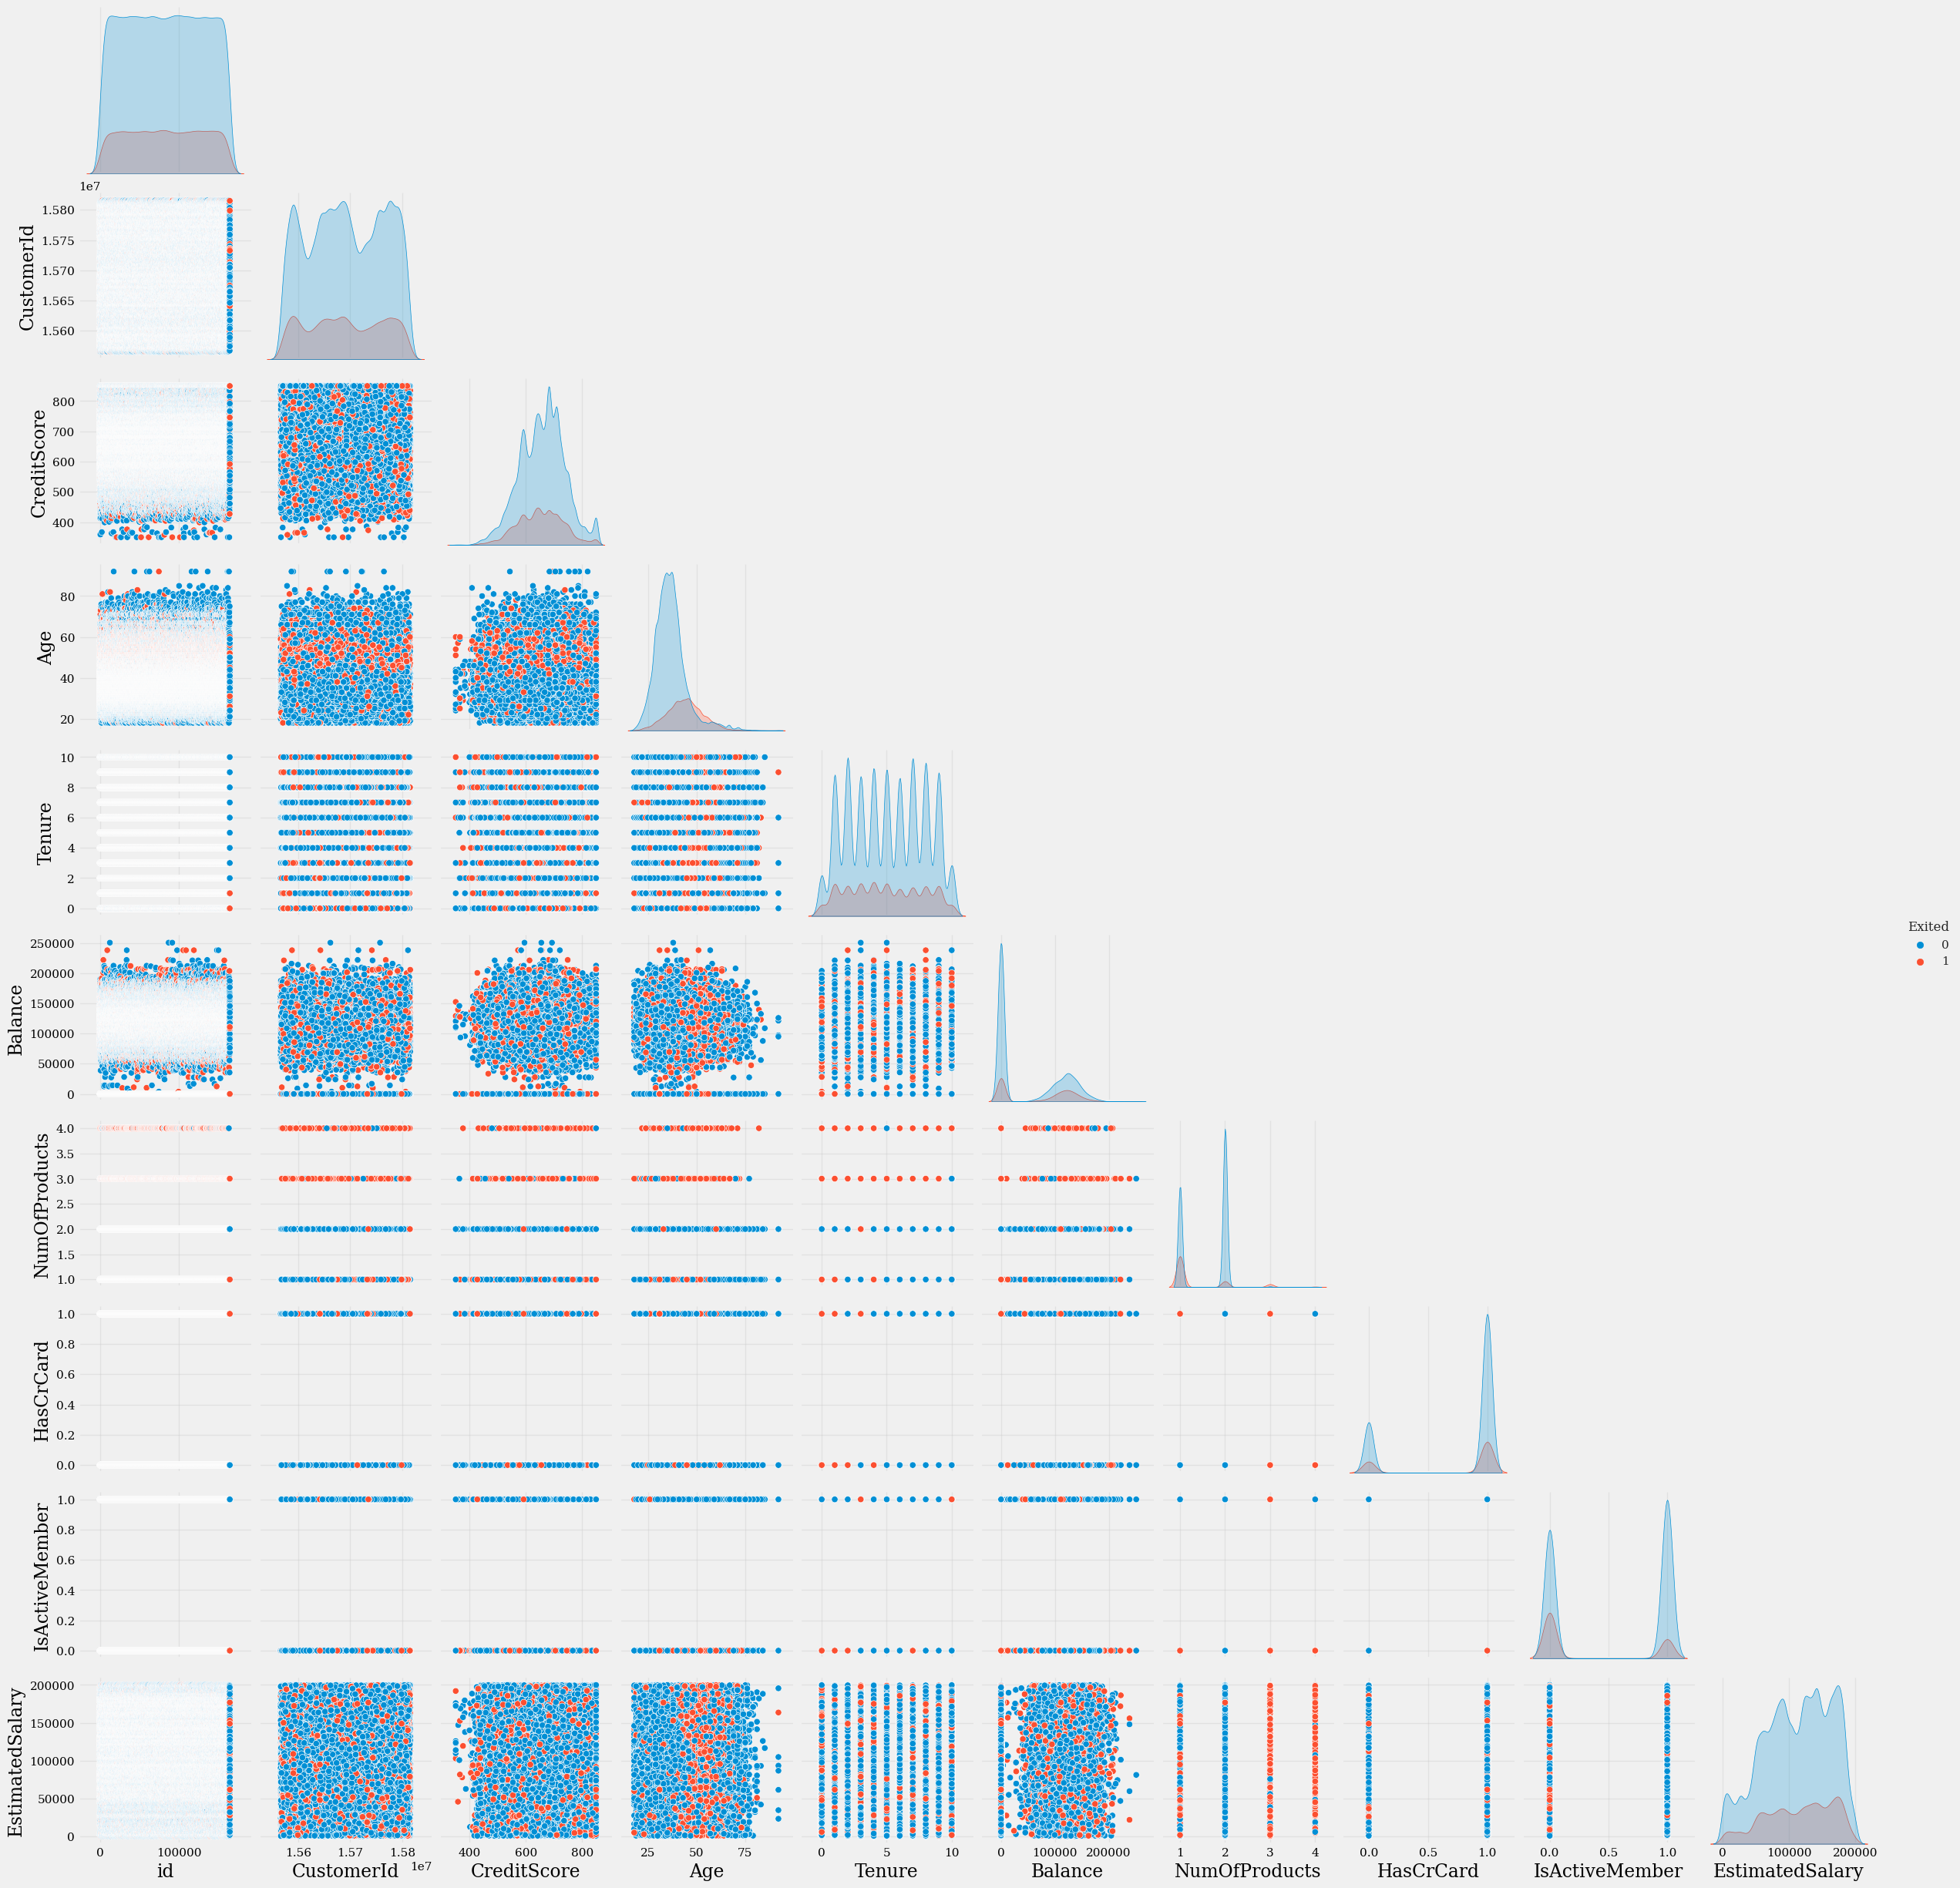

In [24]:
# pairplot for all variables
# sns.pairplot(train_data)
sns.pairplot(train_data, hue="Exited", corner=True)
plt.show()

C:\Users\admin\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


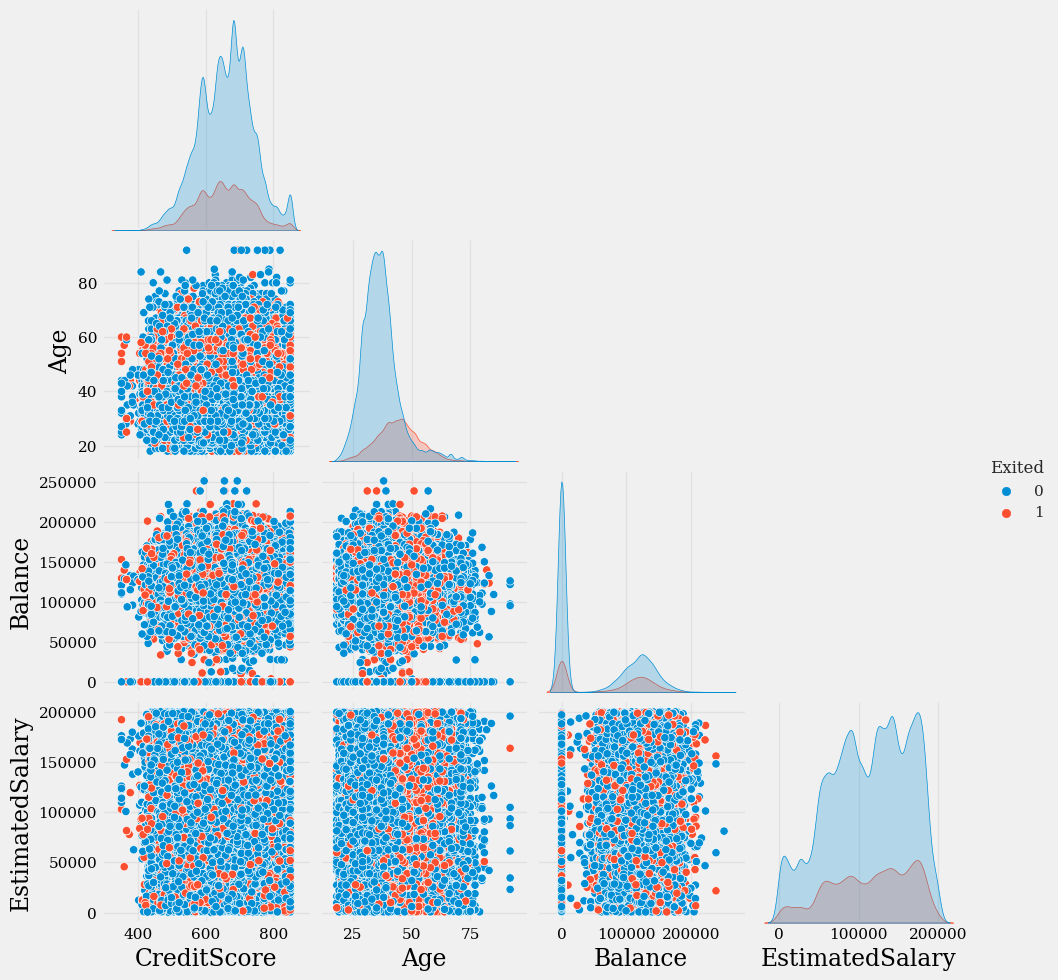

In [26]:
# Multivariate Analysis
df3 = train_data[['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'Exited']].copy()
sns.pairplot(df3, hue="Exited", corner=True)
plt.show()

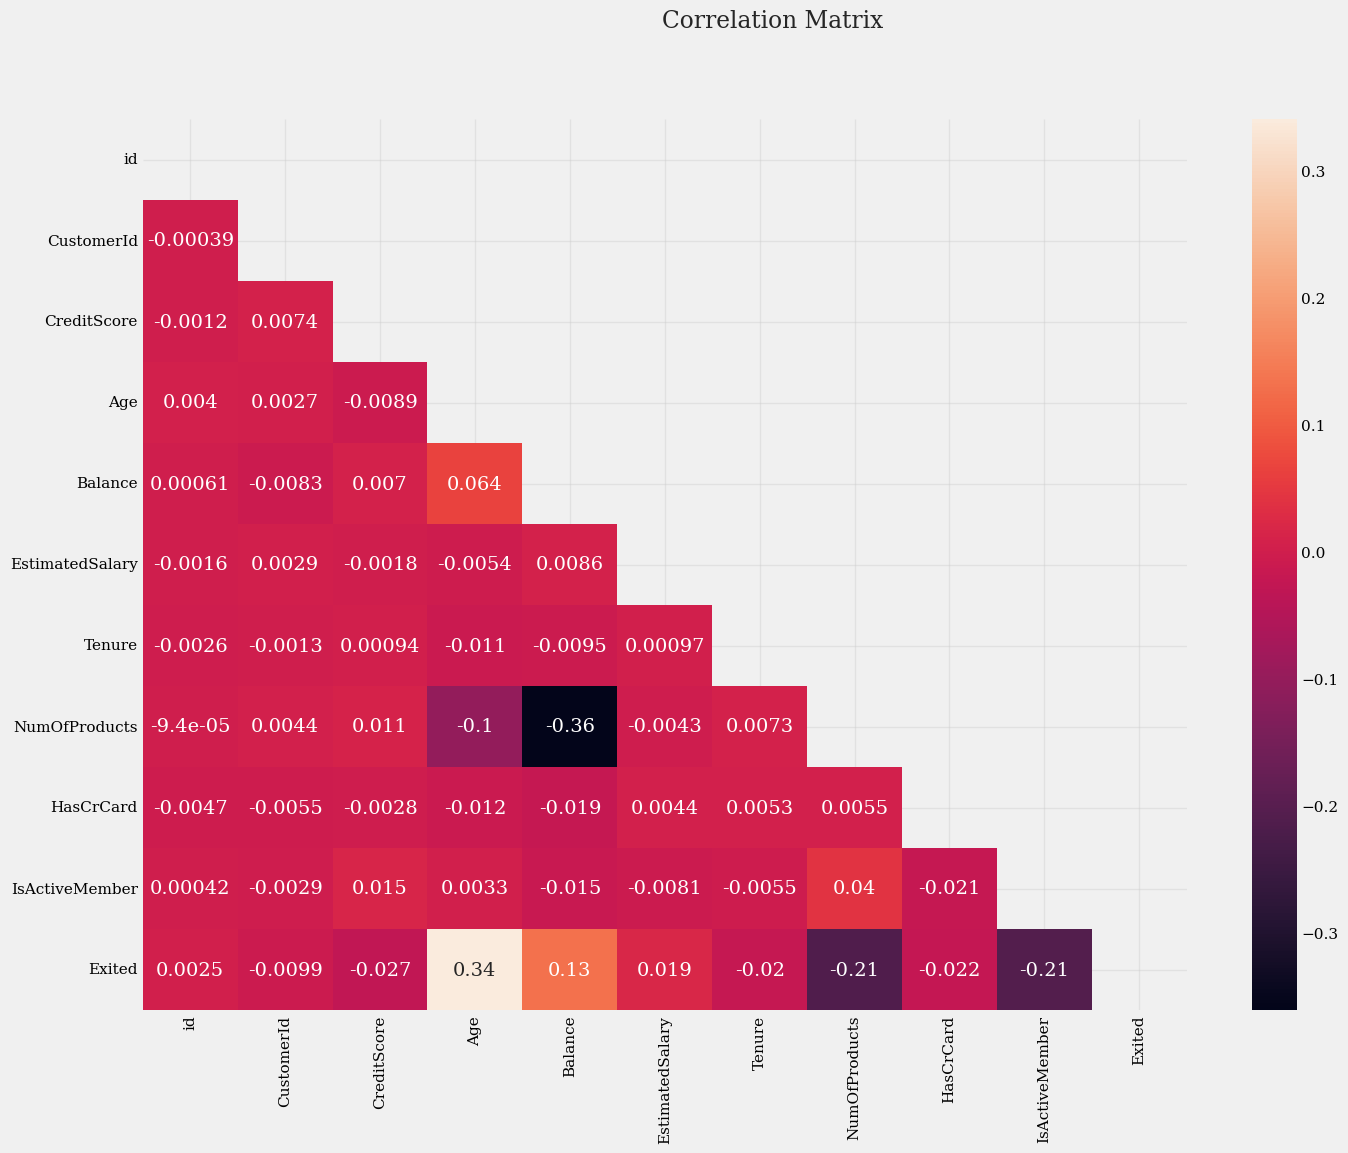

In [27]:
# Correlation Analysis
df4 = train_data[['id', 'CustomerId', 'CreditScore', 'Age', 'Balance', 'EstimatedSalary',
       'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited']].copy()

corr_matrix=df4.corr()

mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

f,ax=plt.subplots(figsize=(15,11))
sns.heatmap(corr_matrix, mask=mask, annot=True)
plt.suptitle('Correlation Matrix')
plt.show()

모델을 사용하여 훈련하고 예측 각 모델마다 반복적으로 사용

In [31]:
train_data.head(10)

id  CustomerId         Surname  CreditScore Geography  Gender   Age  \
0   0    15674932  Okwudilichukwu          668    France    Male  33.0   
1   1    15749177   Okwudiliolisa          627    France    Male  33.0   
2   2    15694510           Hsueh          678    France    Male  40.0   
3   3    15741417             Kao          581    France    Male  34.0   
4   4    15766172       Chiemenam          716     Spain    Male  33.0   
5   5    15771669        Genovese          588   Germany    Male  36.0   
6   6    15692819          Ch'ang          593    France  Female  30.0   
7   7    15669611     Chukwuebuka          678     Spain    Male  37.0   
8   8    15691707           Manna          676    France    Male  43.0   
9   9    15591721        Cattaneo          583   Germany    Male  40.0   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       3       0.00              2        1.0             0.0   
1       1       0.00              2        1.0             1.0   
2      10       0.00              2        1.0             0.0   
3       2  148882.54              1        1.0             1.0   
4       5       0.00              2        1.0             1.0   
5       4  131778.58              1        1.0             0.0   
6       8  144772.69              1        1.0             0.0   
7       1  138476.41              1        1.0             0.0   
8       4       0.00              2        1.0             0.0   
9       4   81274.33              1        1.0             1.0   

   EstimatedSalary  Exited  
0        181449.97       0  
1         49503.50       0  
2        184866.69       0  
3         84560.88       0  
4         15068.83       0  
5        136024.31       1  
6         29792.11       0  
7        106851.60       0  
8        142917.13       0  
9        170843.07       0

In [33]:
train_X = train_data.drop(['id', 'CustomerId', 'Surname', 'Exited'], axis=1)
train_y = train_data['Exited']

In [35]:
# OneHot encoding for categorical variables
X = pd.get_dummies(train_X, columns=['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember'])
y = train_y
feature_names = X.columns

In [37]:
test_X = test_data.drop(['id', 'CustomerId', 'Surname'], axis=1)
test_X_data = pd.get_dummies(test_X, columns=['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember'])

In [39]:
#data frame changes to array
scaler = StandardScaler()
X = scaler.fit_transform(X)
test_X_data = scaler.fit_transform(test_X_data)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [43]:
logit = LogisticRegression(random_state=42)
logit.fit(X_train, y_train)

y_pred_logit = logit.predict(X_test)
y_prob_logit = logit.predict_proba(X_test)[:, 1]

print("logistic regression accuracy:")
print(classification_report(y_test, y_pred_logit))

importances = logit.coef_[0]
names = feature_names

accuracy_logit = accuracy_score(y_test, y_pred_logit)
auc_logit = roc_auc_score(y_test, y_prob_logit)
print(f"\nLogistic Regression - Accuracy: {accuracy_logit * 100:.2f}%, AUC: {auc_logit:.4f}")

logistic regression accuracy:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     26023
           1       0.72      0.51      0.60      6984

    accuracy                           0.86     33007
   macro avg       0.80      0.73      0.76     33007
weighted avg       0.85      0.86      0.85     33007


Logistic Regression - Accuracy: 85.57%, AUC: 0.8698


In [45]:
y_scores = {}
y_scores['Logistic Regression'] = y_prob_logit

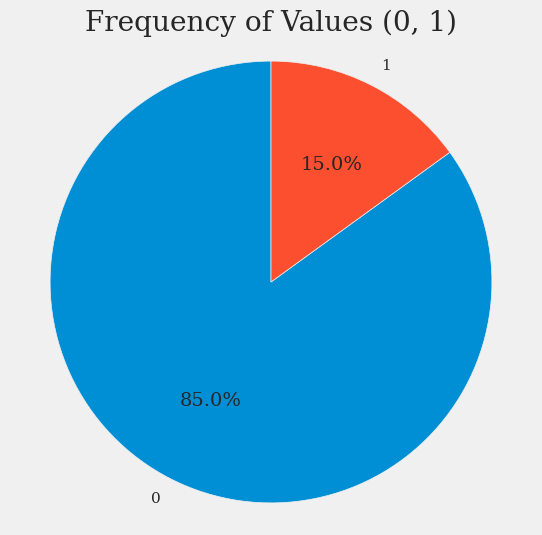

In [47]:
counts = np.bincount(y_pred_logit)
labels = ['0','1']
valid_counts = counts[:len(labels)]
    
plt.figure(figsize=(6, 6))
plt.pie(valid_counts, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Frequency of Values (0, 1)')
plt.axis('equal') 
plt.show()

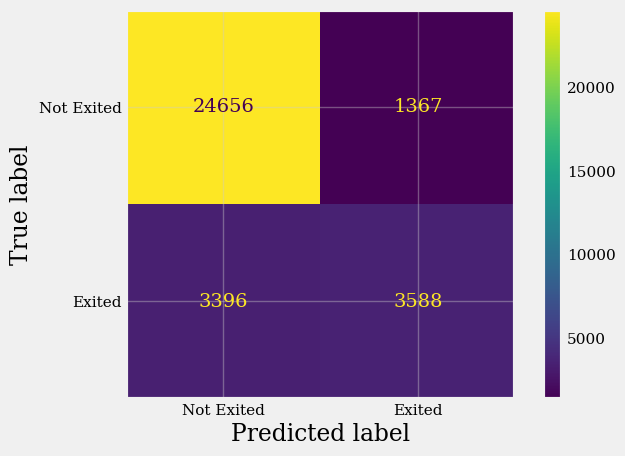

In [49]:
cm = confusion_matrix(y_test, y_pred_logit)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Exited', 'Exited'])
disp.plot()
plt.show()

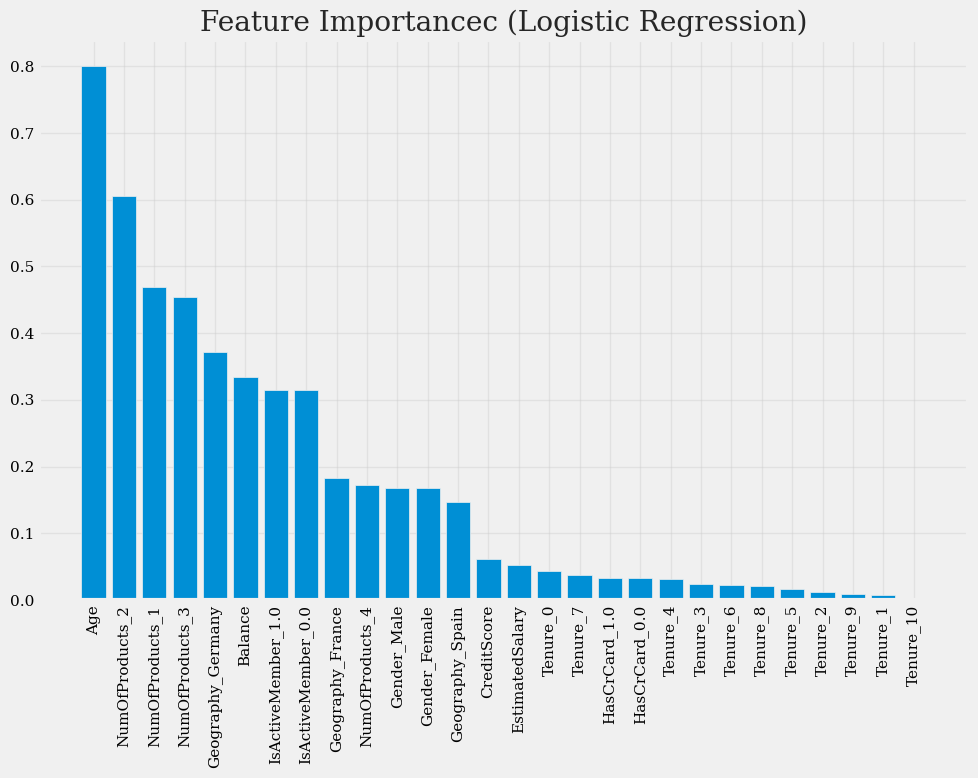

In [55]:
indices = np.argsort(abs(importances))[::-1]
plt.figure(figsize=(10, 8))
plt.bar(range(len(importances)), np.abs(importances[indices]))
plt.xticks(range(len(importances)), [names[i] for i in indices], rotation=90)
plt.title('Feature Importancec (Logistic Regression)')
plt.tight_layout()
plt.show()

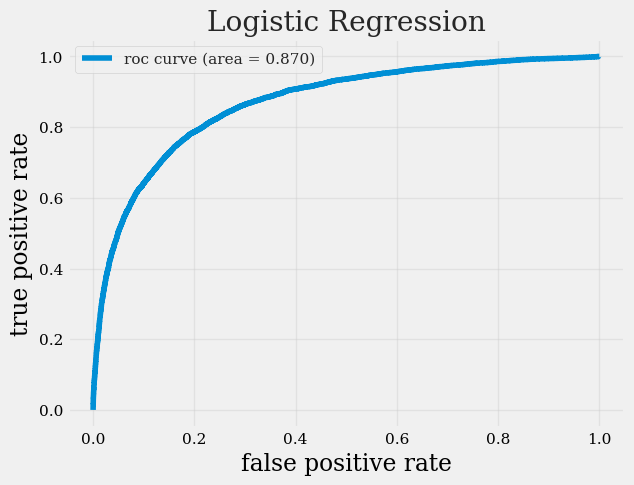

In [57]:
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_prob_logit)
plt.plot(fpr, tpr, label='roc curve (area = %0.3f)' % auc(fpr, tpr))
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Logistic Regression')
plt.show()

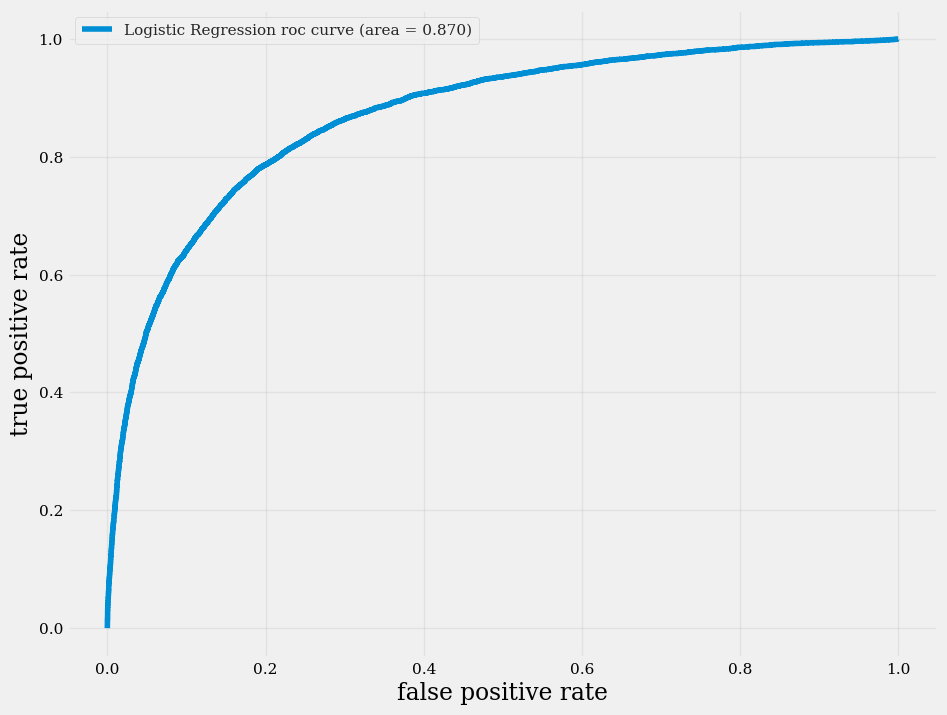

In [59]:
plt.figure(figsize=(10, 8))
for model_name in y_scores.keys():    
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_scores[model_name])
    plt.plot(fpr, tpr, label=f'{model_name} roc curve (area = %0.3f)' % auc(fpr, tpr))
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

In [61]:
submission_logit = sample_submission.drop(['Exited'], axis=1)
submission_logit['Exited'] = logit.predict_proba(test_X_data)[:, 1]
submission_logit.head(10)

id    Exited
0  165034  0.010893
1  165035  0.659506
2  165036  0.070955
3  165037  0.288259
4  165038  0.483955
5  165039  0.030702
6  165040  0.036368
7  165041  0.074719
8  165042  0.543371
9  165043  0.010910

In [63]:
submission_logit.to_csv(r"data/submission_logit_scaled.csv", index=False)

In [65]:
rforest = RandomForestClassifier(random_state=42)
rforest.fit(X_train, y_train)

y_pred_rf = rforest.predict(X_test)
y_prob_rf = rforest.predict_proba(X_test)[:, 1]

print("\nRandom Forest accuracy:")
print(classification_report(y_test, y_pred_rf))

importances = rforest.feature_importances_
names = feature_names

accuracy_rf = accuracy_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_prob_rf)
print(f"\nRandom Forest - Accuracy: {accuracy_rf * 100:.2f}%, AUC: {auc_rf:.4f}")


Random Forest accuracy:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     26023
           1       0.72      0.53      0.61      6984

    accuracy                           0.86     33007
   macro avg       0.80      0.74      0.76     33007
weighted avg       0.85      0.86      0.85     33007


Random Forest - Accuracy: 85.64%, AUC: 0.8710


In [67]:
y_scores['Random Forest'] = y_prob_rf

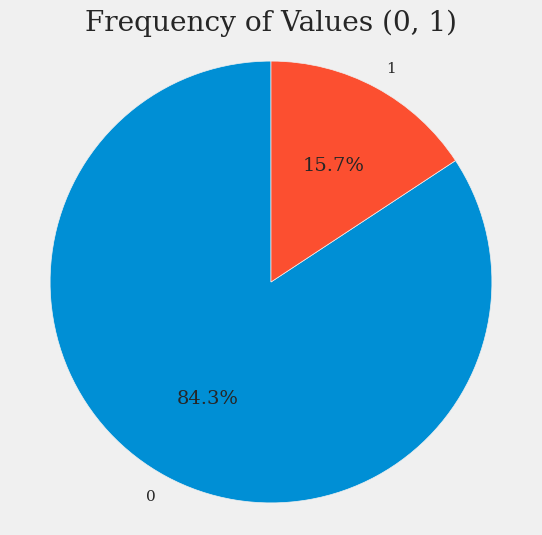

In [69]:
counts = np.bincount(y_pred_rf)
labels = ['0','1']
valid_counts = counts[:len(labels)]
    
plt.figure(figsize=(6, 6))
plt.pie(valid_counts, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Frequency of Values (0, 1)')
plt.axis('equal')
plt.show()

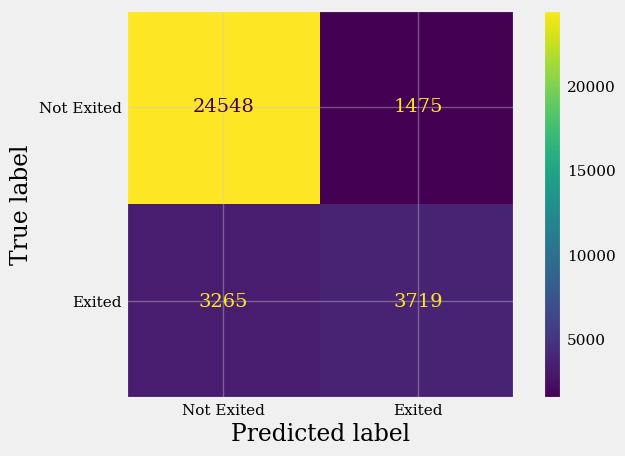

In [71]:
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Exited', 'Exited'])
disp.plot()
plt.show()

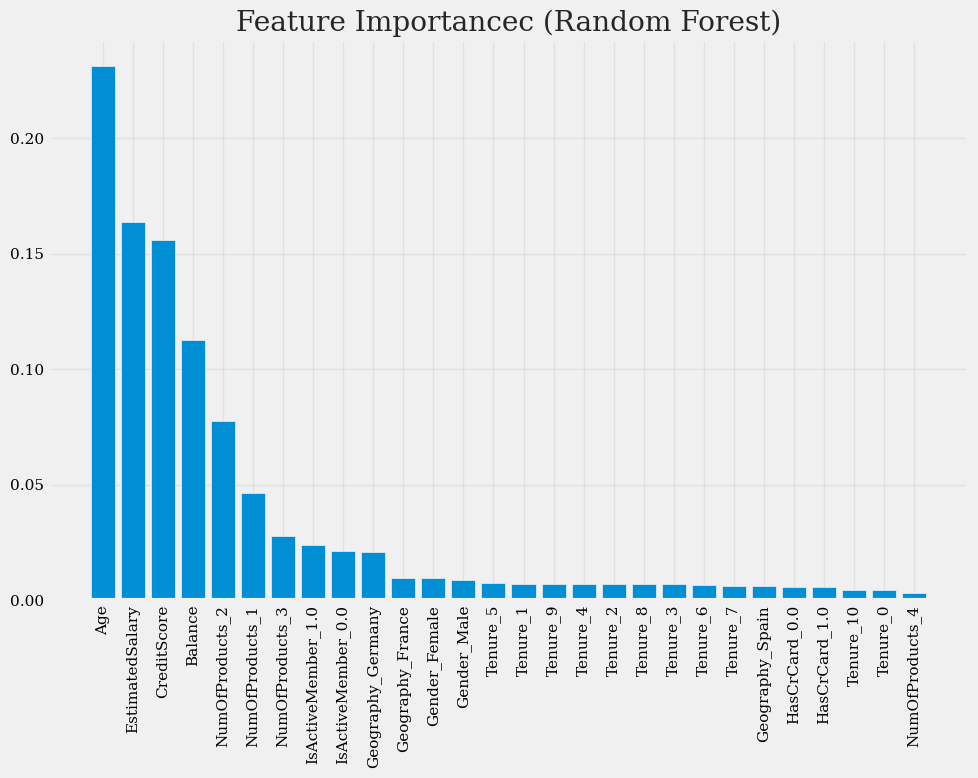

In [75]:
indices = np.argsort(abs(importances))[::-1]
plt.figure(figsize=(10, 8))
plt.bar(range(len(importances)), np.abs(importances[indices]))
plt.xticks(range(len(importances)), [names[i] for i in indices], rotation=90)
plt.title('Feature Importancec (Random Forest)')
plt.tight_layout()
plt.show()

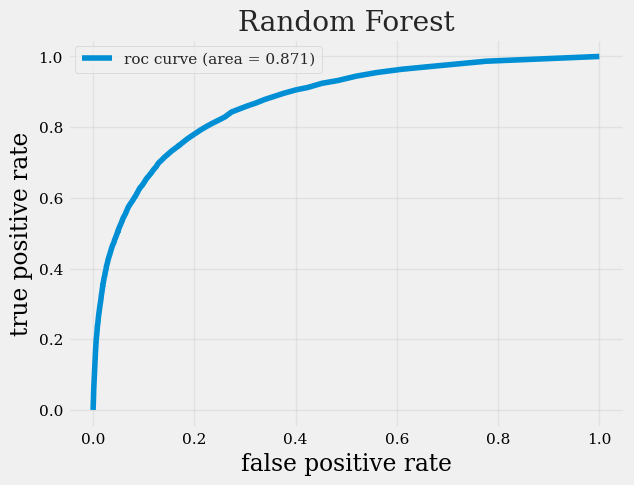

In [77]:
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_prob_rf)
plt.plot(fpr, tpr, label='roc curve (area = %0.3f)' % auc(fpr, tpr))
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Random Forest')
plt.show()

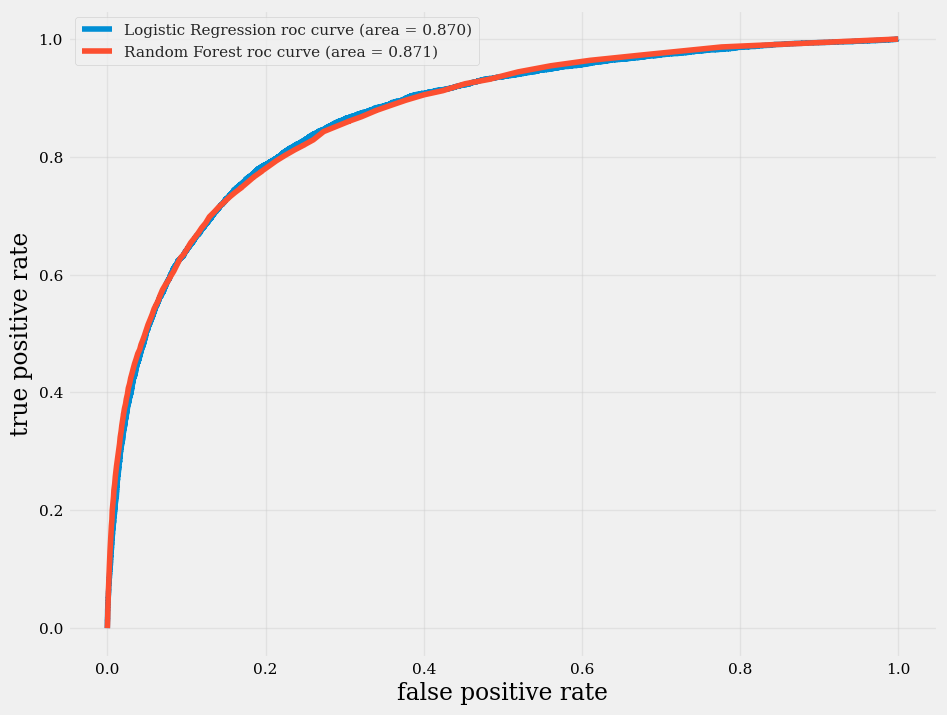

In [79]:
plt.figure(figsize=(10, 8))
for model_name in y_scores.keys():    
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_scores[model_name])
    plt.plot(fpr, tpr, label=f'{model_name} roc curve (area = %0.3f)' % auc(fpr, tpr))
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

In [81]:
submission_rf = sample_submission.drop(['Exited'], axis=1)
submission_rf['Exited'] = rforest.predict_proba(test_X_data)[:, 1]
submission_rf.head(10)

id  Exited
0  165034    0.04
1  165035    0.98
2  165036    0.00
3  165037    0.14
4  165038    0.39
5  165039    0.03
6  165040    0.01
7  165041    0.05
8  165042    0.56
9  165043    0.01

In [83]:
submission_rf.to_csv(r"data/submission_rf_scaled.csv", index=False)

In [85]:
# LDA(Linear Discriminant Analysis)
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

y_pred_lda = lda.predict(X_test)
y_prob_lda = lda.predict_proba(X_test)[:, 1]

print("LDA accuracy:")
print(classification_report(y_test, y_pred_lda))

importances = lda.coef_[0]
names = feature_names

accuracy_lda = accuracy_score(y_test, y_pred_lda)
auc_lda = roc_auc_score(y_test, y_prob_lda)
print(f"LDA - Accuracy: {accuracy_lda * 100:.2f}%, AUC: {auc_lda:.4f}")

LDA accuracy:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     26023
           1       0.71      0.52      0.60      6984

    accuracy                           0.85     33007
   macro avg       0.80      0.73      0.76     33007
weighted avg       0.85      0.85      0.85     33007

LDA - Accuracy: 85.48%, AUC: 0.8691


In [87]:
y_scores['LDA'] = y_prob_lda

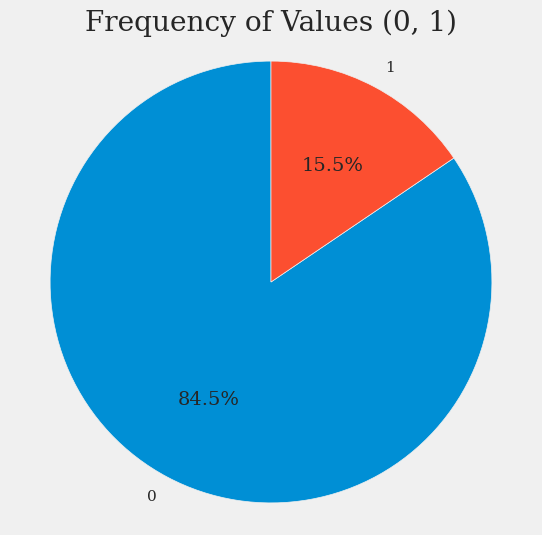

In [89]:
counts = np.bincount(y_pred_lda)
labels = ['0','1']
valid_counts = counts[:len(labels)]
    
plt.figure(figsize=(6, 6))
plt.pie(valid_counts, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Frequency of Values (0, 1)')
plt.axis('equal')
plt.show()

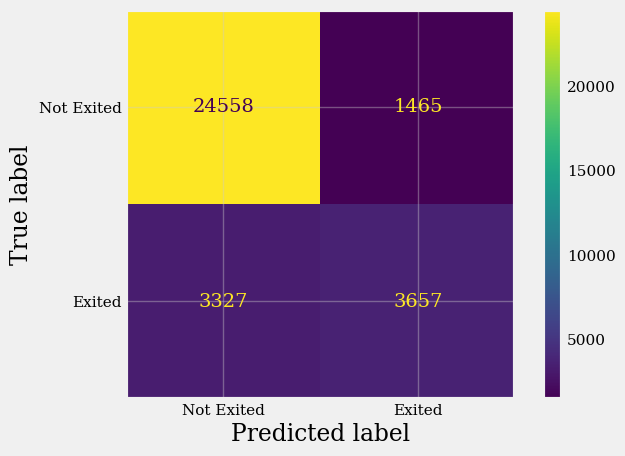

In [91]:
cm = confusion_matrix(y_test, y_pred_lda)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Exited', 'Exited'])
disp.plot()
plt.show()

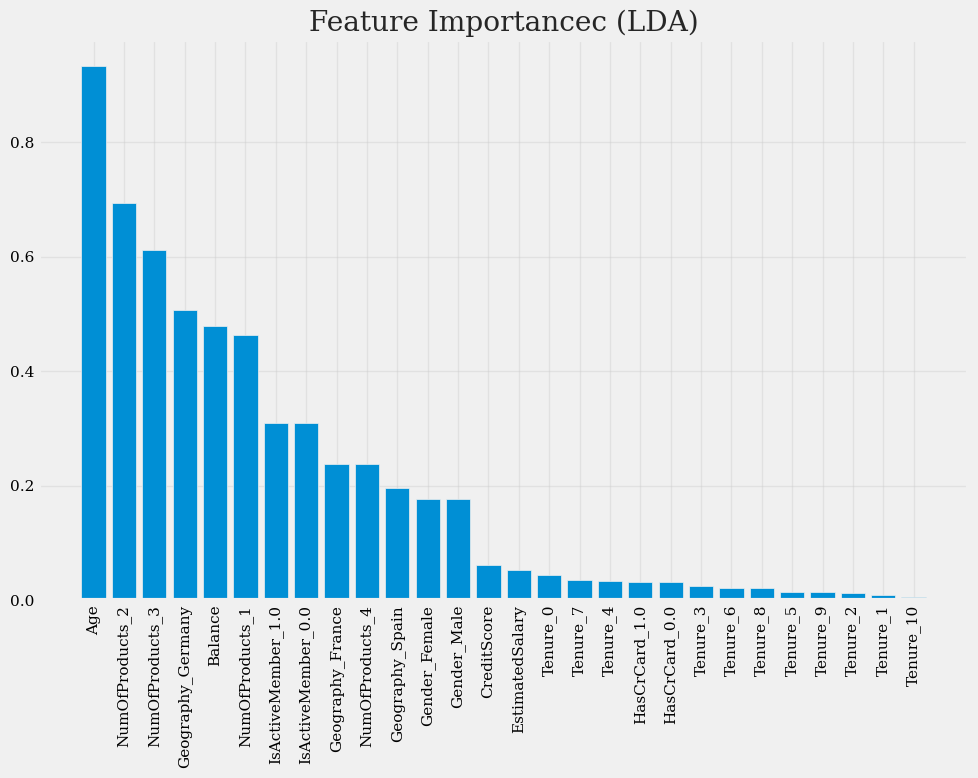

In [95]:
indices = np.argsort(abs(importances))[::-1]
plt.figure(figsize=(10, 8))
plt.bar(range(len(importances)), np.abs(importances[indices]))
plt.xticks(range(len(importances)), [names[i] for i in indices], rotation=90)
plt.title('Feature Importancec (LDA)')
plt.tight_layout()
plt.show()

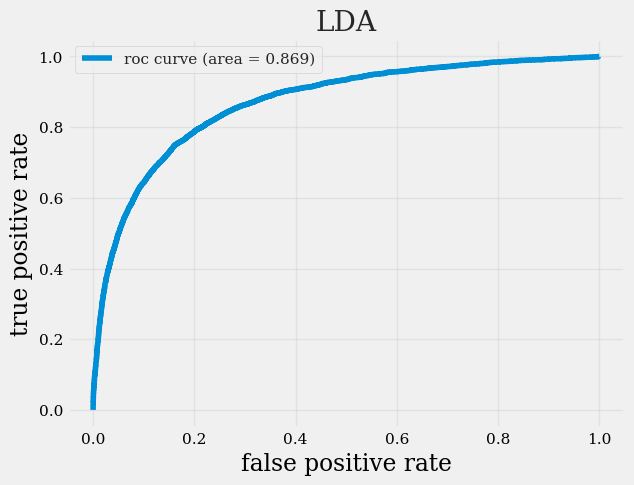

In [97]:
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_prob_lda)
plt.plot(fpr, tpr, label='roc curve (area = %0.3f)' % auc(fpr, tpr))
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('LDA')
plt.show()

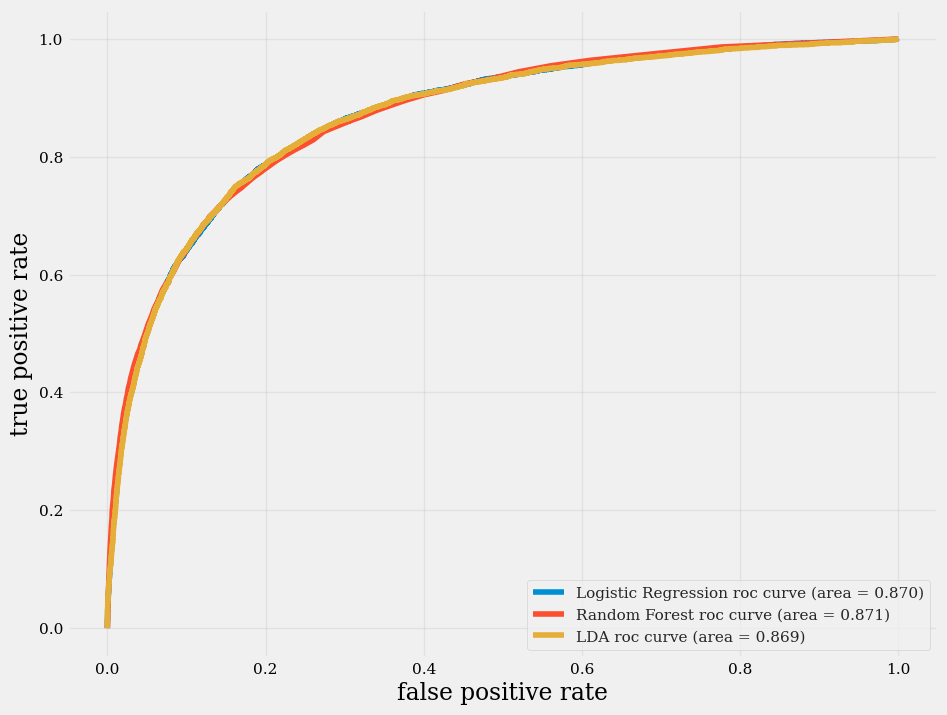

In [99]:
plt.figure(figsize=(10, 8))
for model_name in y_scores.keys():
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_scores[model_name])
    plt.plot(fpr, tpr, label=f'{model_name} roc curve (area = %0.3f)' % auc(fpr, tpr))
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

In [101]:
submission_lda = sample_submission.drop(['Exited'], axis=1)
submission_lda['Exited'] = lda.predict_proba(test_X_data)[:, 1]
submission_lda.head(10)

id    Exited
0  165034  0.007307
1  165035  0.678042
2  165036  0.056460
3  165037  0.267551
4  165038  0.506383
5  165039  0.019678
6  165040  0.033020
7  165041  0.072070
8  165042  0.506059
9  165043  0.007760

In [103]:
submission_lda.to_csv(r"data/submission_lda_scaled.csv", index=False)

In [105]:
#QDA
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)

y_pred_qda = qda.predict(X_test)
y_prob_qda = qda.predict_proba(X_test)[:, 1]

print("QDA accuracy:")
print(classification_report(y_test, y_pred_qda))

names = feature_names
importances = np.abs(qda.means_[0] - qda.means_[1])

accuracy_qda = accuracy_score(y_test, y_pred_qda)
auc_qda = roc_auc_score(y_test, y_prob_qda)
print(f"QDA - Accuracy: {accuracy_qda * 100:.2f}%, AUC: {auc_qda:.4f}")

QDA accuracy:
              precision    recall  f1-score   support

           0       0.85      0.65      0.74     26023
           1       0.31      0.59      0.41      6984

    accuracy                           0.64     33007
   macro avg       0.58      0.62      0.57     33007
weighted avg       0.74      0.64      0.67     33007

QDA - Accuracy: 63.60%, AUC: 0.6675


C:\Users\admin\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [107]:
y_scores['QDA'] = y_prob_qda

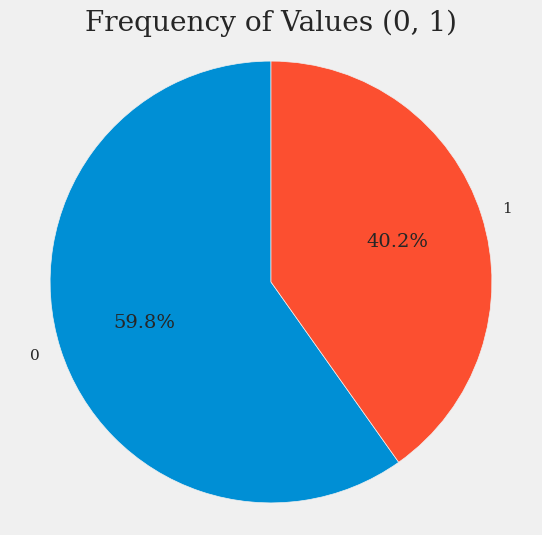

In [109]:
counts = np.bincount(y_pred_qda)
labels = ['0','1']
valid_counts = counts[:len(labels)]
    
plt.figure(figsize=(6, 6))
plt.pie(valid_counts, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Frequency of Values (0, 1)')
plt.axis('equal')
plt.show()

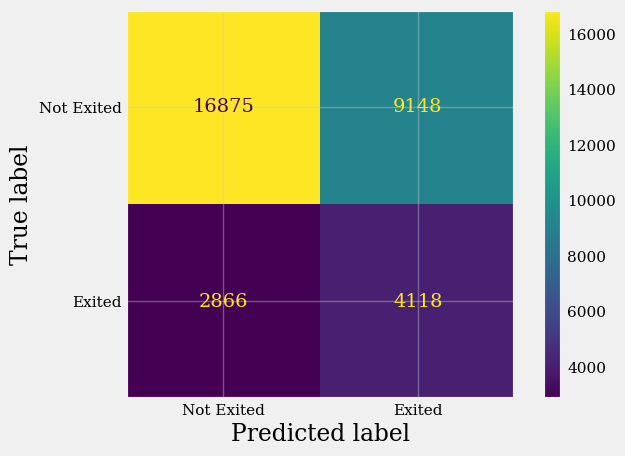

In [111]:
cm = confusion_matrix(y_test, y_pred_qda)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Exited', 'Exited'])
disp.plot()
plt.show()

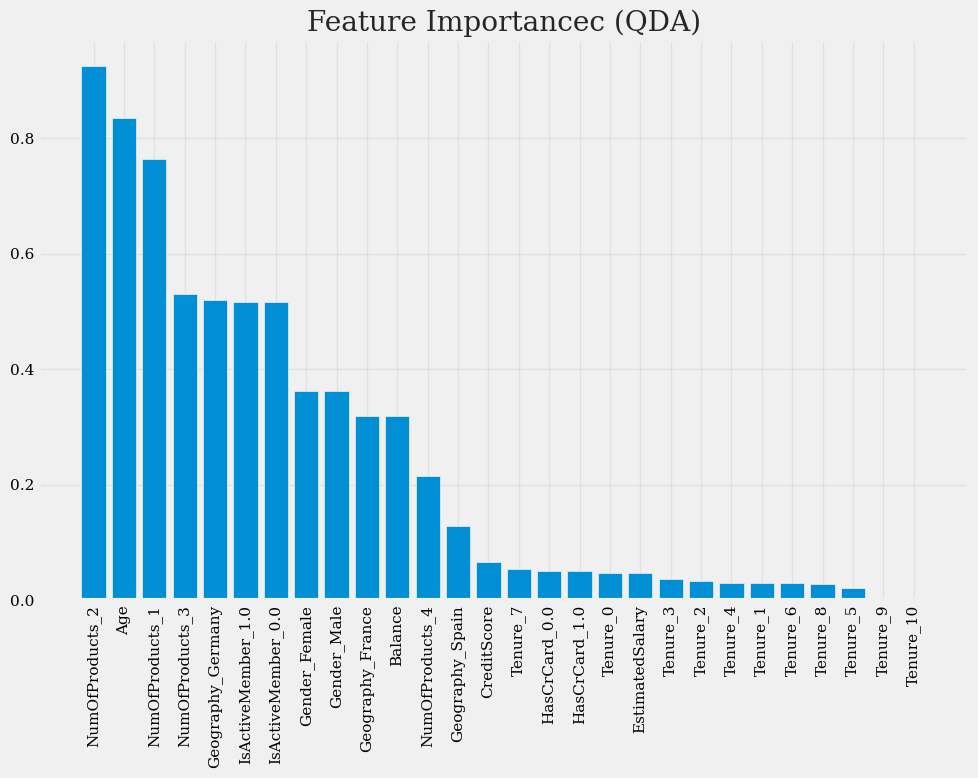

In [117]:
indices = np.argsort(abs(importances))[::-1]
plt.figure(figsize=(10, 8))
plt.bar(range(len(importances)), np.abs(importances[indices]))
plt.xticks(range(len(importances)), [names[i] for i in indices], rotation=90)
plt.title('Feature Importancec (QDA)')
plt.tight_layout()
plt.show()

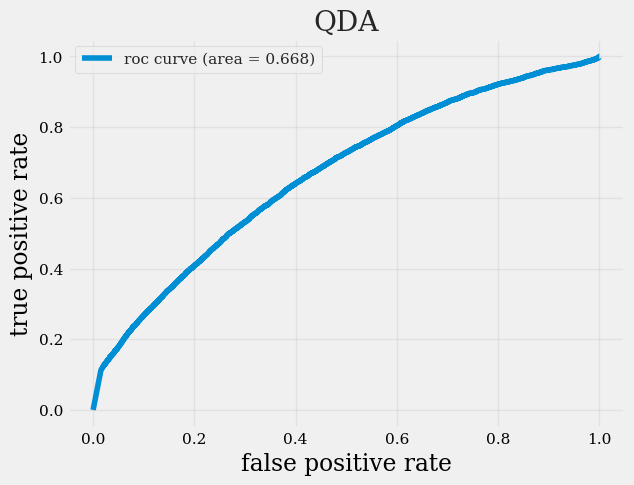

In [119]:
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_prob_qda)
plt.plot(fpr, tpr, label='roc curve (area = %0.3f)' % auc(fpr, tpr))
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('QDA')
plt.show()

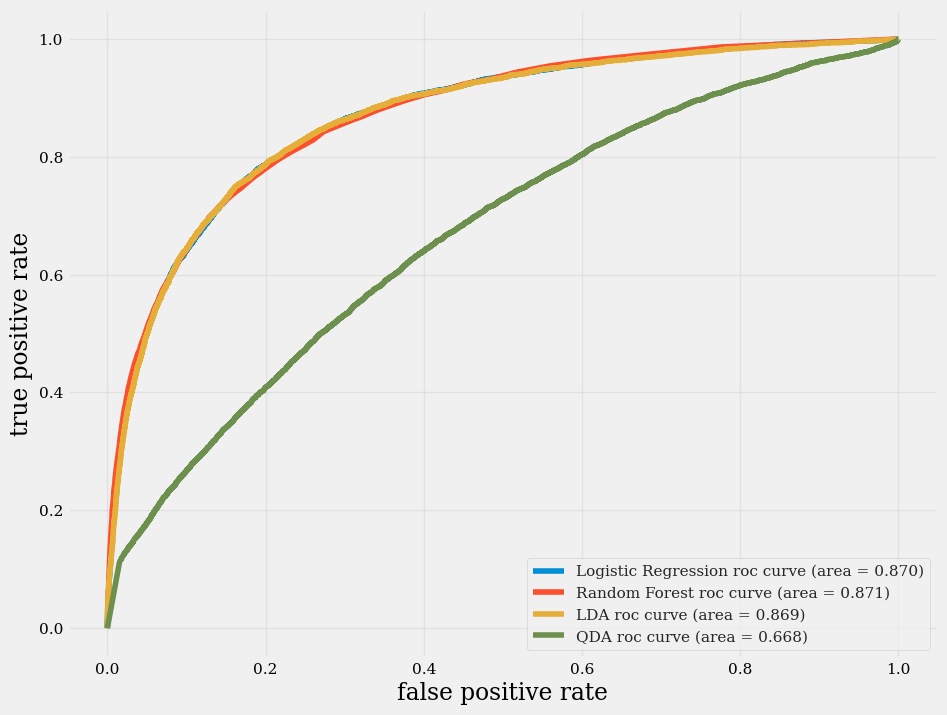

In [121]:
plt.figure(figsize=(10, 8))
for model_name in y_scores.keys():
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_scores[model_name])
    plt.plot(fpr, tpr, label=f'{model_name} roc curve (area = %0.3f)' % auc(fpr, tpr))
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

In [123]:
submission_qda = sample_submission.drop(['Exited'], axis=1)
submission_qda['Exited'] = qda.predict_proba(test_X_data)[:, 1]
submission_qda.head(10)

id  Exited
0  165034     0.0
1  165035     0.0
2  165036     0.0
3  165037     0.0
4  165038     0.0
5  165039     0.0
6  165040     0.0
7  165041     0.0
8  165042     0.0
9  165043     0.0

In [125]:
submission_qda.to_csv(r"data/submission_qda_scaled.csv", index=False)

In [127]:
# XGBoost
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("XGBoost accuracy:")
print(classification_report(y_test, y_pred_xgb))

names = feature_names
importances = xgb_model.feature_importances_

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
auc_xgb = roc_auc_score(y_test, y_prob_xgb)
print(f"XGBoost - Accuracy: {accuracy_xgb * 100:.2f}%, AUC: {auc_xgb:.4f}")

XGBoost accuracy:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     26023
           1       0.74      0.56      0.64      6984

    accuracy                           0.86     33007
   macro avg       0.81      0.75      0.78     33007
weighted avg       0.86      0.86      0.86     33007

XGBoost - Accuracy: 86.47%, AUC: 0.8862


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

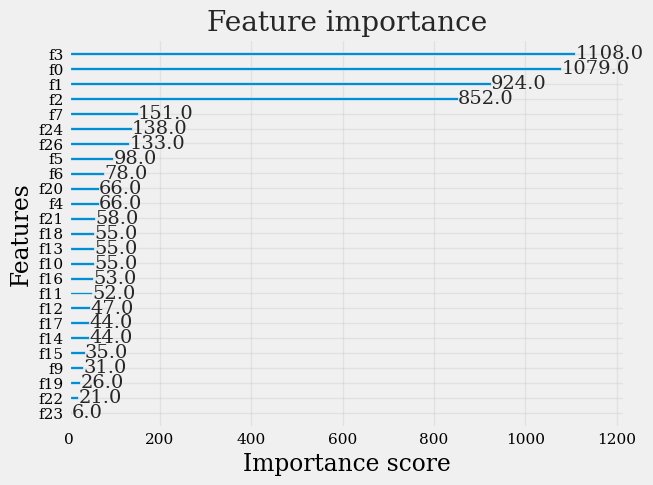

In [131]:
from xgboost import plot_importance
plot_importance(xgb_model)

In [133]:
y_scores['XGB'] = y_prob_xgb

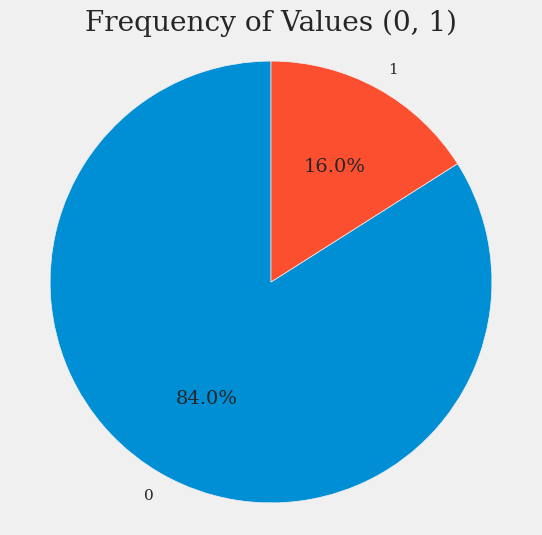

In [135]:
counts = np.bincount(y_pred_xgb)
labels = ['0','1']
valid_counts = counts[:len(labels)]
    
plt.figure(figsize=(6, 6))
plt.pie(valid_counts, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Frequency of Values (0, 1)')
plt.axis('equal')
plt.show()

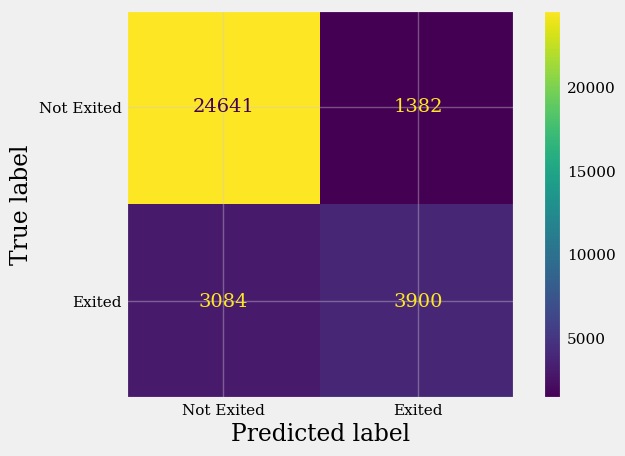

In [153]:
cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Exited', 'Exited'])
disp.plot()
plt.show()

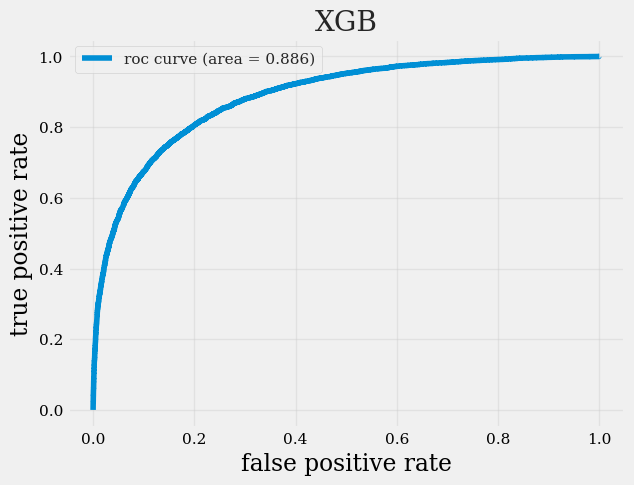

In [159]:
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_prob_xgb)
plt.plot(fpr, tpr, label='roc curve (area = %0.3f)' % auc(fpr, tpr))
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('XGB')
plt.show()

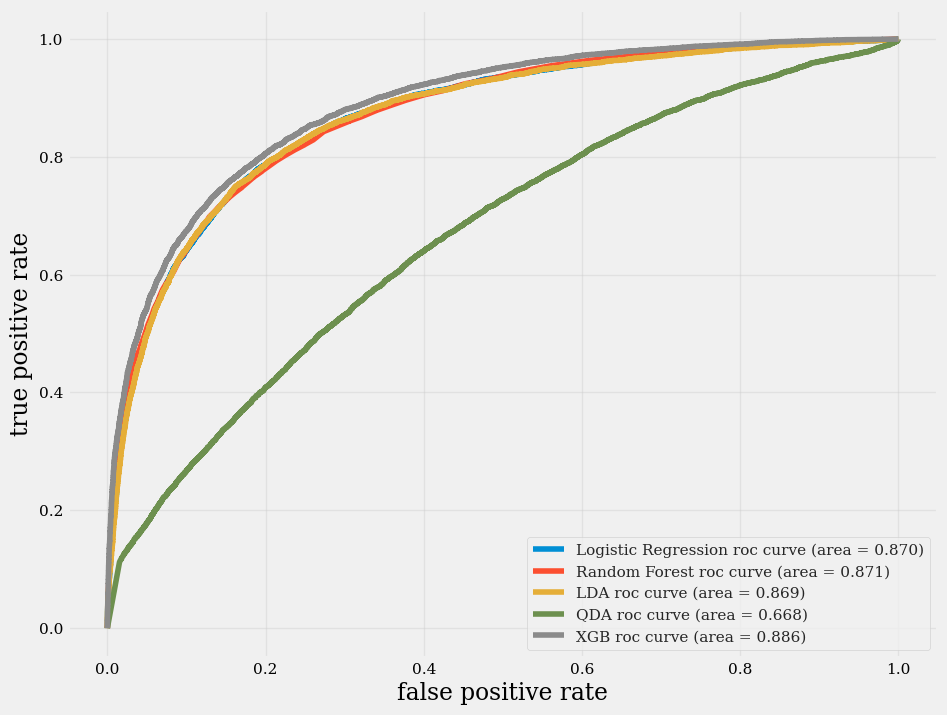

In [161]:
plt.figure(figsize=(10, 8))
for model_name in y_scores.keys():
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_scores[model_name])
    plt.plot(fpr, tpr, label=f'{model_name} roc curve (area = %0.3f)' % auc(fpr, tpr))
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

In [163]:
submission_xgb = sample_submission.drop(['Exited'], axis=1)
submission_xgb['Exited'] = xgb_model.predict_proba(test_X_data)[:, 1]
submission_xgb.head(10)

id    Exited
0  165034  0.580815
1  165035  0.495898
2  165036  0.598687
3  165037  0.097228
4  165038  0.211218
5  165039  0.372153
6  165040  0.809971
7  165041  0.823451
8  165042  0.158304
9  165043  0.508686

In [165]:
submission_xgb.to_csv(r"data/submission_xgb_scaled.csv", index=False)

In [188]:
#SVM
svm = SVC(probability=True, random_state=42)
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)
y_prob_svm = svm.predict_proba(X_test)[:, 1]

print("SVM accuracy:")
print(classification_report(y_test, y_pred_xgb))

accuracy_svm = accuracy_score(y_test, y_pred_svm)
auc_svm = roc_auc_score(y_test, y_prob_svm)
print(f"Support Vector Machine - Accuracy: {accuracy_svm * 100:.2f}%, AUC: {auc_svm:.4f}")

SVM accuracy:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     26023
           1       0.74      0.56      0.64      6984

    accuracy                           0.86     33007
   macro avg       0.81      0.75      0.78     33007
weighted avg       0.86      0.86      0.86     33007

Support Vector Machine - Accuracy: 85.96%, AUC: 0.8180


In [169]:
y_scores['SVM-default'] = y_prob_svm

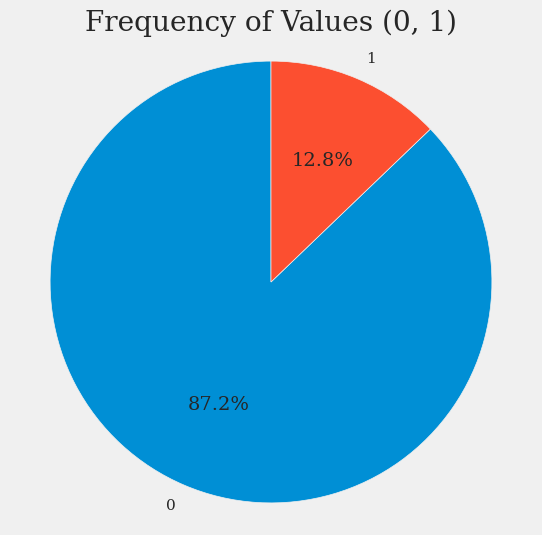

In [171]:
counts = np.bincount(y_pred_svm)
if len(counts) == 1:
    counts = np.append(counts,[0])    
labels = ['0','1']
valid_counts = counts[:len(labels)]
    
plt.figure(figsize=(6, 6))
plt.pie(valid_counts, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Frequency of Values (0, 1)')
plt.axis('equal')
plt.show()

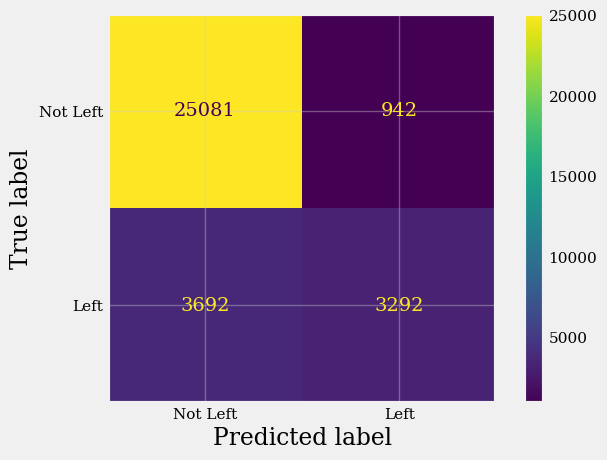

In [173]:
cm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Left', 'Left'])
disp.plot()
plt.show()

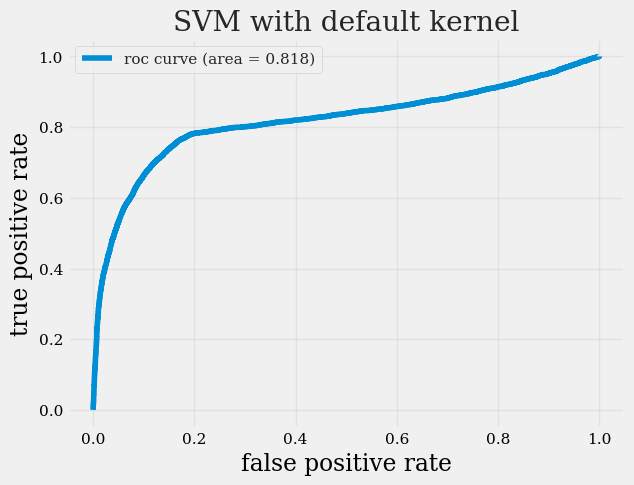

In [175]:
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_prob_svm)
plt.plot(fpr, tpr, label='roc curve (area = %0.3f)' % auc(fpr, tpr))
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('SVM with default kernel')
plt.show()

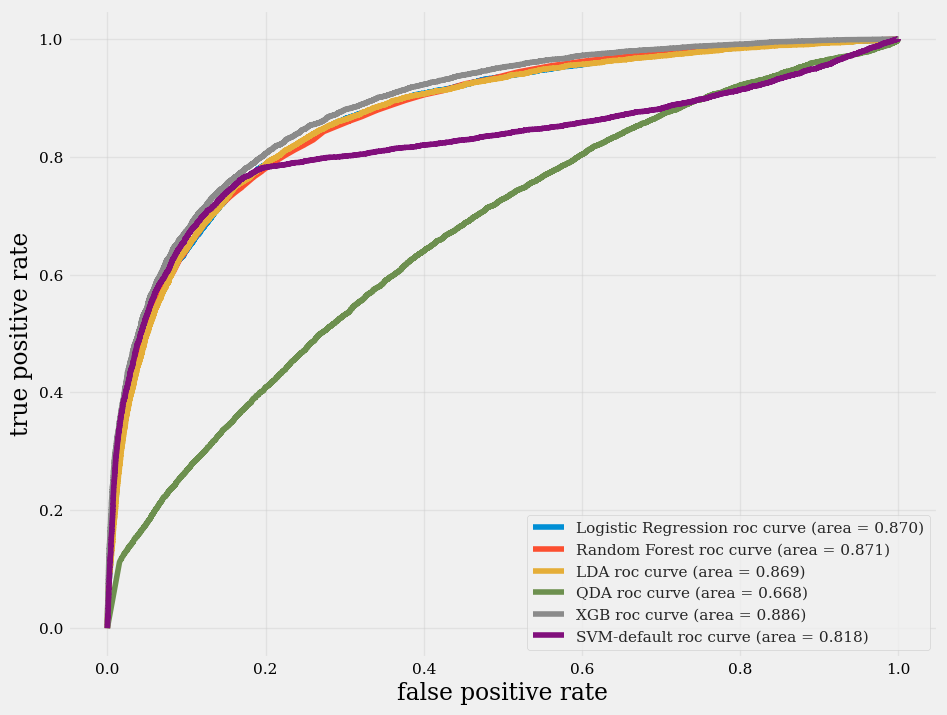

In [177]:
plt.figure(figsize=(10, 8))
for model_name in y_scores.keys():
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_scores[model_name])
    plt.plot(fpr, tpr, label=f'{model_name} roc curve (area = %0.3f)' % auc(fpr, tpr))
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

In [179]:
submission_svm = sample_submission.drop(['Exited'], axis=1)
submission_svm['Exited'] = svm.predict_proba(test_X_data)[:, 1]
submission_svm.head(10)

id    Exited
0  165034  0.111223
1  165035  0.894768
2  165036  0.106152
3  165037  0.131242
4  165038  0.370695
5  165039  0.121784
6  165040  0.114498
7  165041  0.119368
8  165042  0.489075
9  165043  0.117496

In [181]:
submission_svm.to_csv(r"data/submission_svm_scaled.csv", index=False)

In [190]:
#SVM
svm = SVC(kernel='linear', probability=True, random_state=42)
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)
y_prob_svm = svm.predict_proba(X_test)[:, 1]  

print("SVM accuracy:")
print(classification_report(y_test, y_pred_xgb))

accuracy_svm = accuracy_score(y_test, y_pred_svm)
auc_svm = roc_auc_score(y_test, y_prob_svm)
print(f"Support Vector Machine - Accuracy: {accuracy_svm * 100:.2f}%, AUC: {auc_svm:.4f}")

SVM accuracy:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     26023
           1       0.74      0.56      0.64      6984

    accuracy                           0.86     33007
   macro avg       0.81      0.75      0.78     33007
weighted avg       0.86      0.86      0.86     33007

Support Vector Machine - Accuracy: 85.54%, AUC: 0.8670


In [192]:
y_scores['SVM-linear'] = y_prob_svm

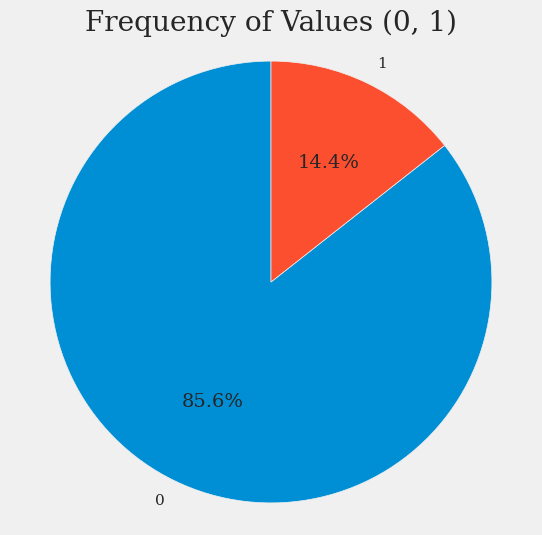

In [194]:
counts = np.bincount(y_pred_svm)
if len(counts) == 1:
    counts = np.append(counts,[0])    
labels = ['0','1']
valid_counts = counts[:len(labels)]
    
plt.figure(figsize=(6, 6))
plt.pie(valid_counts, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Frequency of Values (0, 1)')
plt.axis('equal')
plt.show()

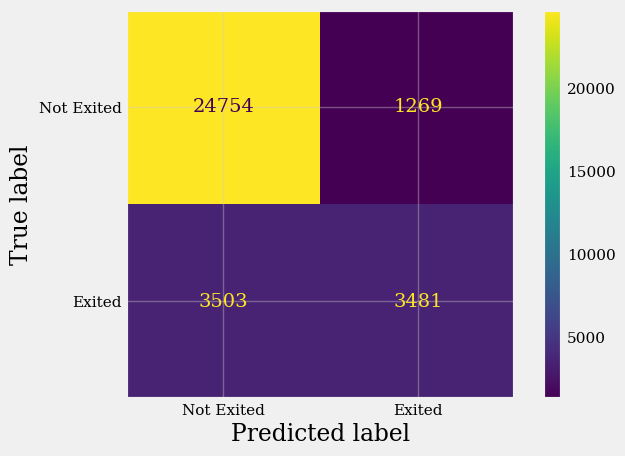

In [196]:
cm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Exited', 'Exited'])
disp.plot()
plt.show()

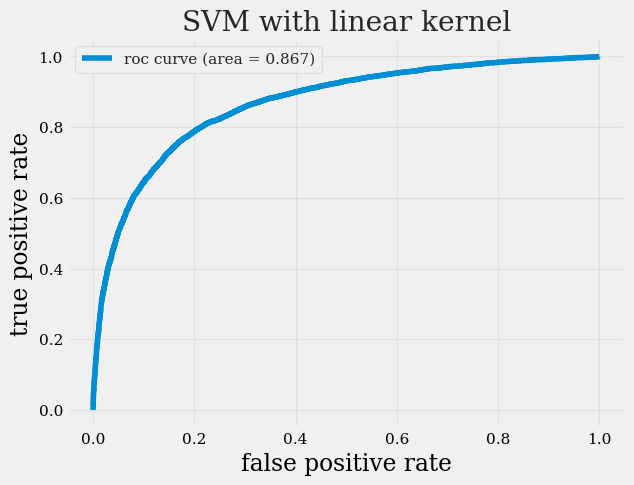

In [198]:
fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_prob_svm)
plt.plot(fpr, tpr, label='roc curve (area = %0.3f)' % auc(fpr, tpr))
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('SVM with linear kernel')
plt.show()

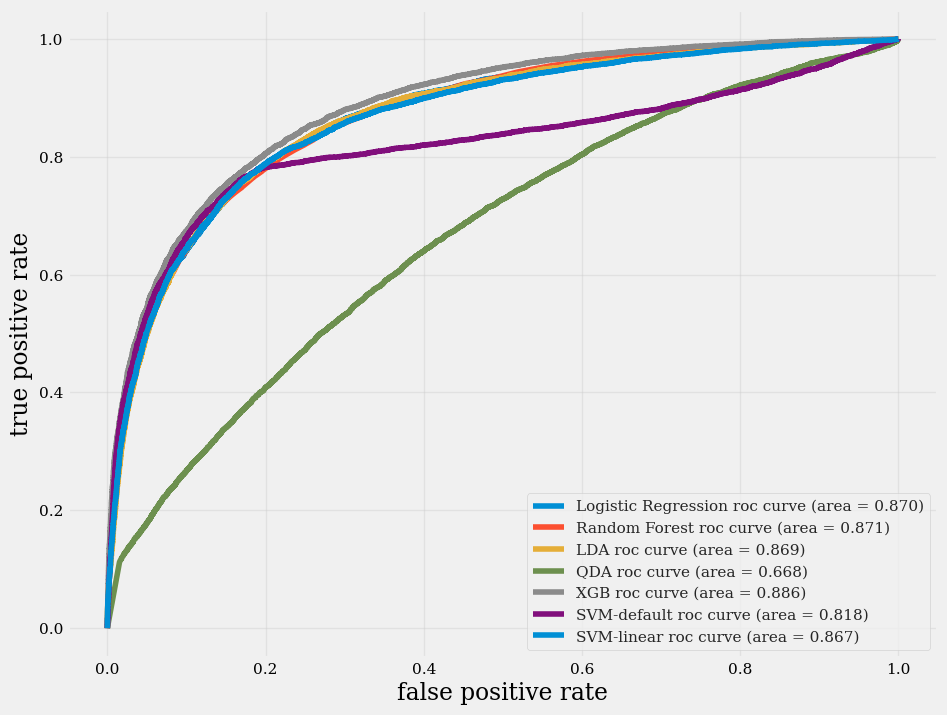

In [200]:
plt.figure(figsize=(10, 8))
for model_name in y_scores.keys():    
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_scores[model_name])
    plt.plot(fpr, tpr, label=f'{model_name} roc curve (area = %0.3f)' % auc(fpr, tpr))
plt.legend()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()

In [202]:
submission_svm = sample_submission.drop(['Exited'], axis=1)
submission_svm['Exited'] = svm.predict_proba(test_X_data)[:, 1]
submission_svm.head(10)

id    Exited
0  165034  0.012321
1  165035  0.676816
2  165036  0.093829
3  165037  0.298530
4  165038  0.477711
5  165039  0.036989
6  165040  0.046606
7  165041  0.092891
8  165042  0.500000
9  165043  0.012507

In [204]:
submission_svm.to_csv(r"data/submission_svm_linear_scaled.csv", index=False)